In [1]:
# import dependencies
import os
import numpy as np
import pandas as pd
import scanpy as sc
import loompy as lp
from MulticoreTSNE import MulticoreTSNE as TSNE
import json
import base64
import zlib
from pyscenic.plotting import plot_binarization
from pyscenic.export import add_scenic_metadata
from pyscenic.cli.utils import load_signatures
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
# set a working directory
wdir = '/mnt/data0/projects/biohub/hassan2022/output/SCENIC/pyscenic_workflow/KENYON/output/TauKI/'
os.chdir( wdir )


# path to loom output, generated from a combination of Scanpy and pySCENIC results:
f_final_loom = 'Kenyon_P251L_scenic_integrated-output.loom'

In [3]:
sc.settings.verbosity = 3 # verbosity: errors (0), warnings (1), info (2), hints (3)
sc.logging.print_versions()
sc.settings.set_figure_params(dpi=150)

-----
anndata     0.8.0
scanpy      1.9.3
-----
MulticoreTSNE       NA
PIL                 9.5.0
attr                23.1.0
backcall            0.2.0
beta_ufunc          NA
binom_ufunc         NA
boltons             NA
cffi                1.15.1
cloudpickle         2.2.1
ctxcore             0.2.0
cycler              0.10.0
cython_runtime      NA
cytoolz             0.12.2
dask                2022.02.0
dateutil            2.8.2
decorator           5.1.1
frozendict          2.3.8
fsspec              2023.1.0
h5py                3.8.0
ipykernel           5.5.5
ipython_genutils    0.2.0
jedi                0.19.0
jinja2              3.1.2
joblib              1.3.2
kiwisolver          1.4.5
llvmlite            0.39.1
loompy              3.0.7
markupsafe          2.1.3
matplotlib          3.5.3
mpl_toolkits        NA
natsort             8.4.0
nbinom_ufunc        NA
networkx            2.6.3
numba               0.56.4
numexpr             2.8.5
numpy               1.21.6
numpy_groupies      0.

In [4]:
# scenic output
lf = lp.connect( f_final_loom, mode='r', validate=False )
meta = json.loads(zlib.decompress(base64.b64decode( lf.attrs.MetaData )))
exprMat = pd.DataFrame( lf[:,:], index=lf.ra.Gene, columns=lf.ca.CellID).T
auc_mtx = pd.DataFrame( lf.ca.RegulonsAUC, index=lf.ca.CellID)

In [5]:

# create a dictionary of regulons:
regulons = {}
for i,r in pd.DataFrame(lf.ra.Regulons,index=lf.ra.Gene).iteritems():
    regulons[i] =  list(r[r==1].index.values)

In [6]:
# cell annotations from the loom column attributes:
cellAnnot = pd.concat(
    [
        pd.DataFrame( lf.ca.Celltype_Garnett, index=lf.ca.CellID ),
        pd.DataFrame( lf.ca.ClusterID, index=lf.ca.CellID ),
        pd.DataFrame( lf.ca.Louvain_clusters_Scanpy, index=lf.ca.CellID ),
        pd.DataFrame( lf.ca.Percent_mito, index=lf.ca.CellID ),
        pd.DataFrame( lf.ca.nGene, index=lf.ca.CellID ),
        pd.DataFrame( lf.ca.nUMI, index=lf.ca.CellID ),
    ],
    axis=1
)
cellAnnot.columns = [
 'Celltype_Garnett',
 'ClusterID',
 'Louvain_clusters_Scanpy',
 'Percent_mito',
 'nGene',
 'nUMI']

In [7]:
# capture embeddings:
dr = [
    pd.DataFrame( lf.ca.Embedding, index=lf.ca.CellID )
]
dr_names = [
    meta['embeddings'][0]['name'].replace(" ","_")
]

# add other embeddings
drx = pd.DataFrame( lf.ca.Embeddings_X, index=lf.ca.CellID )
dry = pd.DataFrame( lf.ca.Embeddings_Y, index=lf.ca.CellID )

for i in range( len(drx.columns) ):
    dr.append( pd.concat( [ drx.iloc[:,i], dry.iloc[:,i] ], sort=False, axis=1, join='outer' ))
    dr_names.append( meta['embeddings'][i+1]['name'].replace(" ","_").replace('/','-') )

# rename columns:
for i,x in enumerate( dr ):
    x.columns = ['X','Y']

In [8]:
lf.close()


In [9]:
# helper functions (not yet integrated into pySCENIC):

from pyscenic.utils import load_motifs
import operator as op
from IPython.display import HTML, display

BASE_URL = "http://motifcollections.aertslab.org/v9/logos/"
COLUMN_NAME_LOGO = "MotifLogo"
COLUMN_NAME_MOTIF_ID = "MotifID"
COLUMN_NAME_TARGETS = "TargetGenes"

def display_logos(df: pd.DataFrame, top_target_genes: int = 3, base_url: str = BASE_URL):
    """
    :param df:
    :param base_url:
    """
    # Make sure the original dataframe is not altered.
    df = df.copy()
    
    # Add column with URLs to sequence logo.
    def create_url(motif_id):
        return '<img src="{}{}.png" style="max-height:124px;"></img>'.format(base_url, motif_id)
    df[("Enrichment", COLUMN_NAME_LOGO)] = list(map(create_url, df.index.get_level_values(COLUMN_NAME_MOTIF_ID)))
    
    # Truncate TargetGenes.
    def truncate(col_val):
        return sorted(col_val, key=op.itemgetter(1))[:top_target_genes]
    df[("Enrichment", COLUMN_NAME_TARGETS)] = list(map(truncate, df[("Enrichment", COLUMN_NAME_TARGETS)]))
    
    MAX_COL_WIDTH = pd.get_option('display.max_colwidth')
    pd.set_option('display.max_colwidth', 200)
    display(HTML(df.head().to_html(escape=False)))
    pd.set_option('display.max_colwidth', MAX_COL_WIDTH)

In [10]:
df_motifs = load_motifs('/mnt/data0/projects/biohub/hassan2022/output/SCENIC/pyscenic_workflow/KENYON/output/TauKI/TauKI_reg.csv')

In [11]:
def colorMap( x, palette='bright' ):
    import natsort
    from collections import OrderedDict
    #
    n=len(set(x))
    cpalette = sns.color_palette(palette,n_colors=n )
    cdict = dict( zip( list(set(x)), cpalette ))
    cmap = [ cdict[i] for i in x ]
    cdict = OrderedDict( natsort.natsorted(cdict.items()) )
    return cmap,cdict

def drplot( dr, colorlab, ax, palette='bright', title=None, **kwargs ):
    cmap,cdict = colorMap( colorlab, palette )
    for lab,col in cdict.items():  
        ix = colorlab.loc[colorlab==lab].index
        ax.scatter( dr['X'][ix], dr['Y'][ix], c=[col]*len(ix), alpha=0.7, label=lab, edgecolors='none')
    if( title is not None ):
        ax.set_title(title, fontsize='x-large');
    #
    ax.set_xticks([])
    ax.set_yticks([])
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.spines['bottom'].set_visible(False)
    ax.spines['left'].set_visible(False)

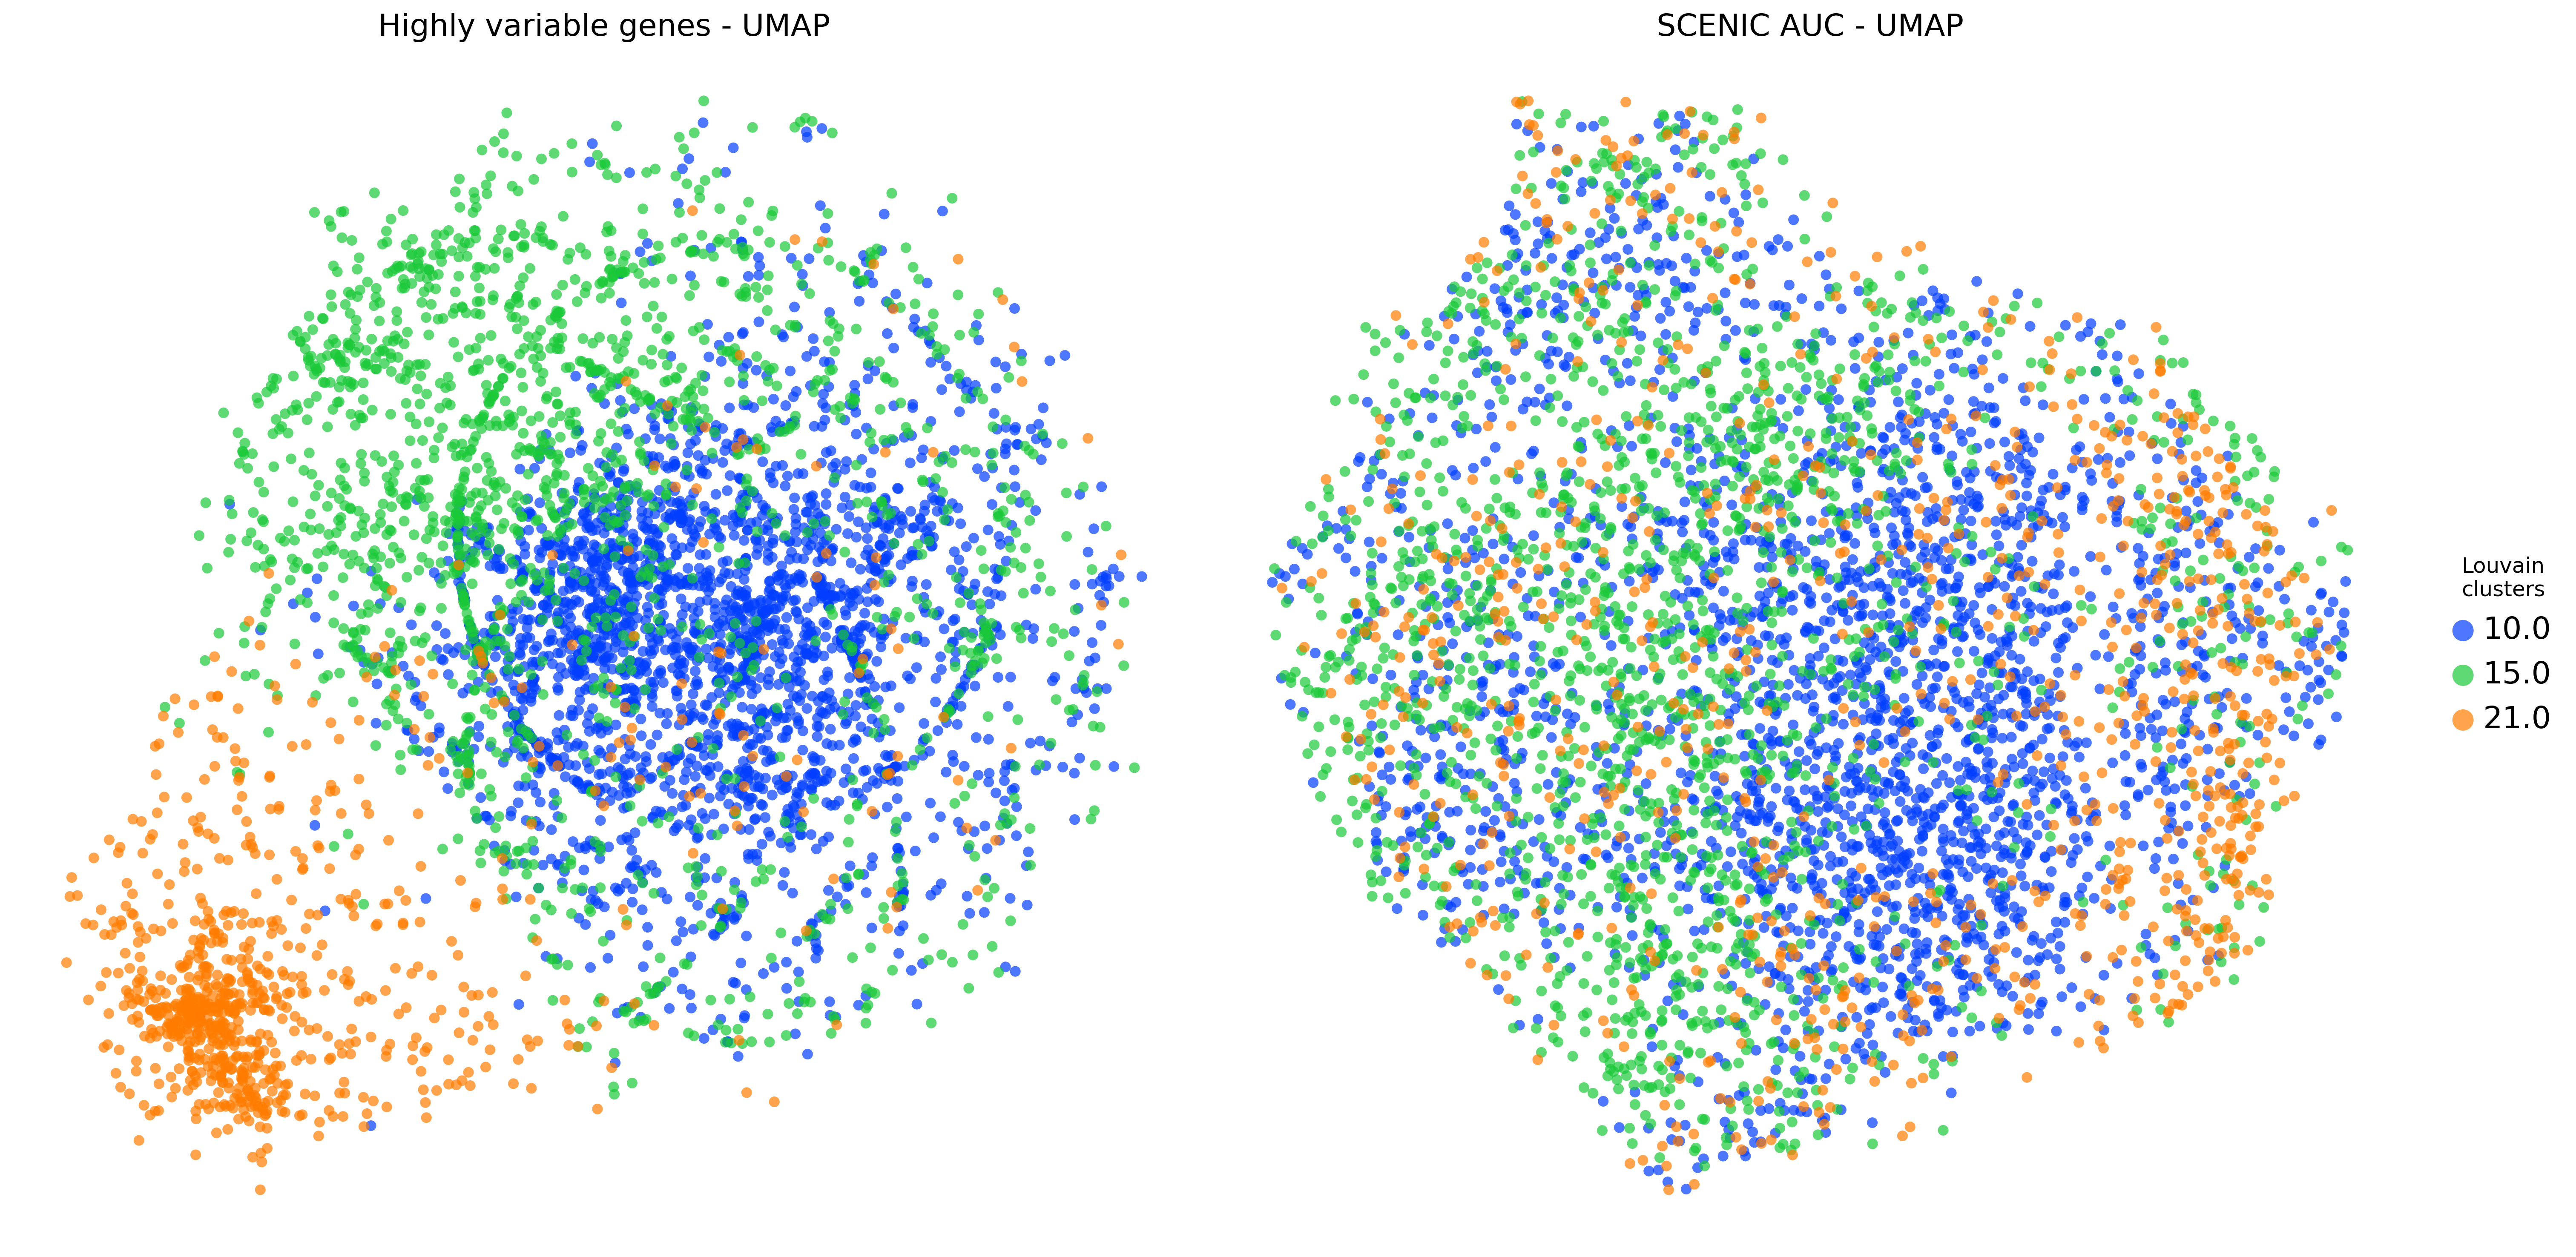

In [12]:
plt.rcParams.update({'font.size':12})

fig, (ax1,ax2) = plt.subplots(1,2, figsize=(20,10), dpi=150 )

drplot( dr[0], colorlab=cellAnnot['Louvain_clusters_Scanpy'], ax=ax1, palette='bright', s=2, title='Highly variable genes - UMAP' )

drplot( dr[4], colorlab=cellAnnot['Louvain_clusters_Scanpy'], ax=ax2, palette='bright', s=2, title='SCENIC AUC - UMAP' )
ax2.legend(loc='right', bbox_to_anchor=(1.15, 0.5), ncol=1, markerscale=2, fontsize='x-large', frameon=False, title="Louvain\nclusters")

plt.tight_layout()
plt.savefig("Kenyon_TauKI_dimred_umap-hvg-scenic-louvain.pdf", dpi=600, bbox_inches = "tight")

# Regulon specificity scores (RSS) across predicted cell types

In [13]:
from pyscenic.rss import regulon_specificity_scores
from pyscenic.plotting import plot_rss
import matplotlib.pyplot as plt
from adjustText import adjust_text
import seaborn as sns
from pyscenic.binarization import binarize

In [14]:
# calculate RSS
rss_cellType = regulon_specificity_scores( auc_mtx, cellAnnot['Celltype_Garnett'] )
rss_cellType

BEAF-32_(+)  Blimp-1_(+)  BtbVII_(+)  CG5641_(+)  CG8319_(+)  \
Kenyon     0.880732     0.928487    0.820277    0.768246    0.805496   

        Cdc5_(+)     D_(+)  E_(bx)_(+)  E_(spl)mgamma-HLH_(+)   ERR_(+)  ...  \
Kenyon  0.893583  0.481538    0.896505               0.282031  0.443613  ...   

          oc_(+)   pho_(+)  scro_(+)   sim_(+)    so_(+)   srp_(+)    tj_(+)  \
Kenyon  0.307651  0.921066  0.832216  0.319624  0.322609  0.430754  0.479894   

         usp_(+)   vvl_(+)  zfh2_(+)  
Kenyon  0.943051  0.388651  0.944994  

[1 rows x 58 columns]

In [15]:
rss_cellType.to_csv("/mnt/data0/projects/biohub/hassan2022/output/SCENIC/pyscenic_workflow/KENYON/output/TauKI/TauKI_rss_cellType.csv")

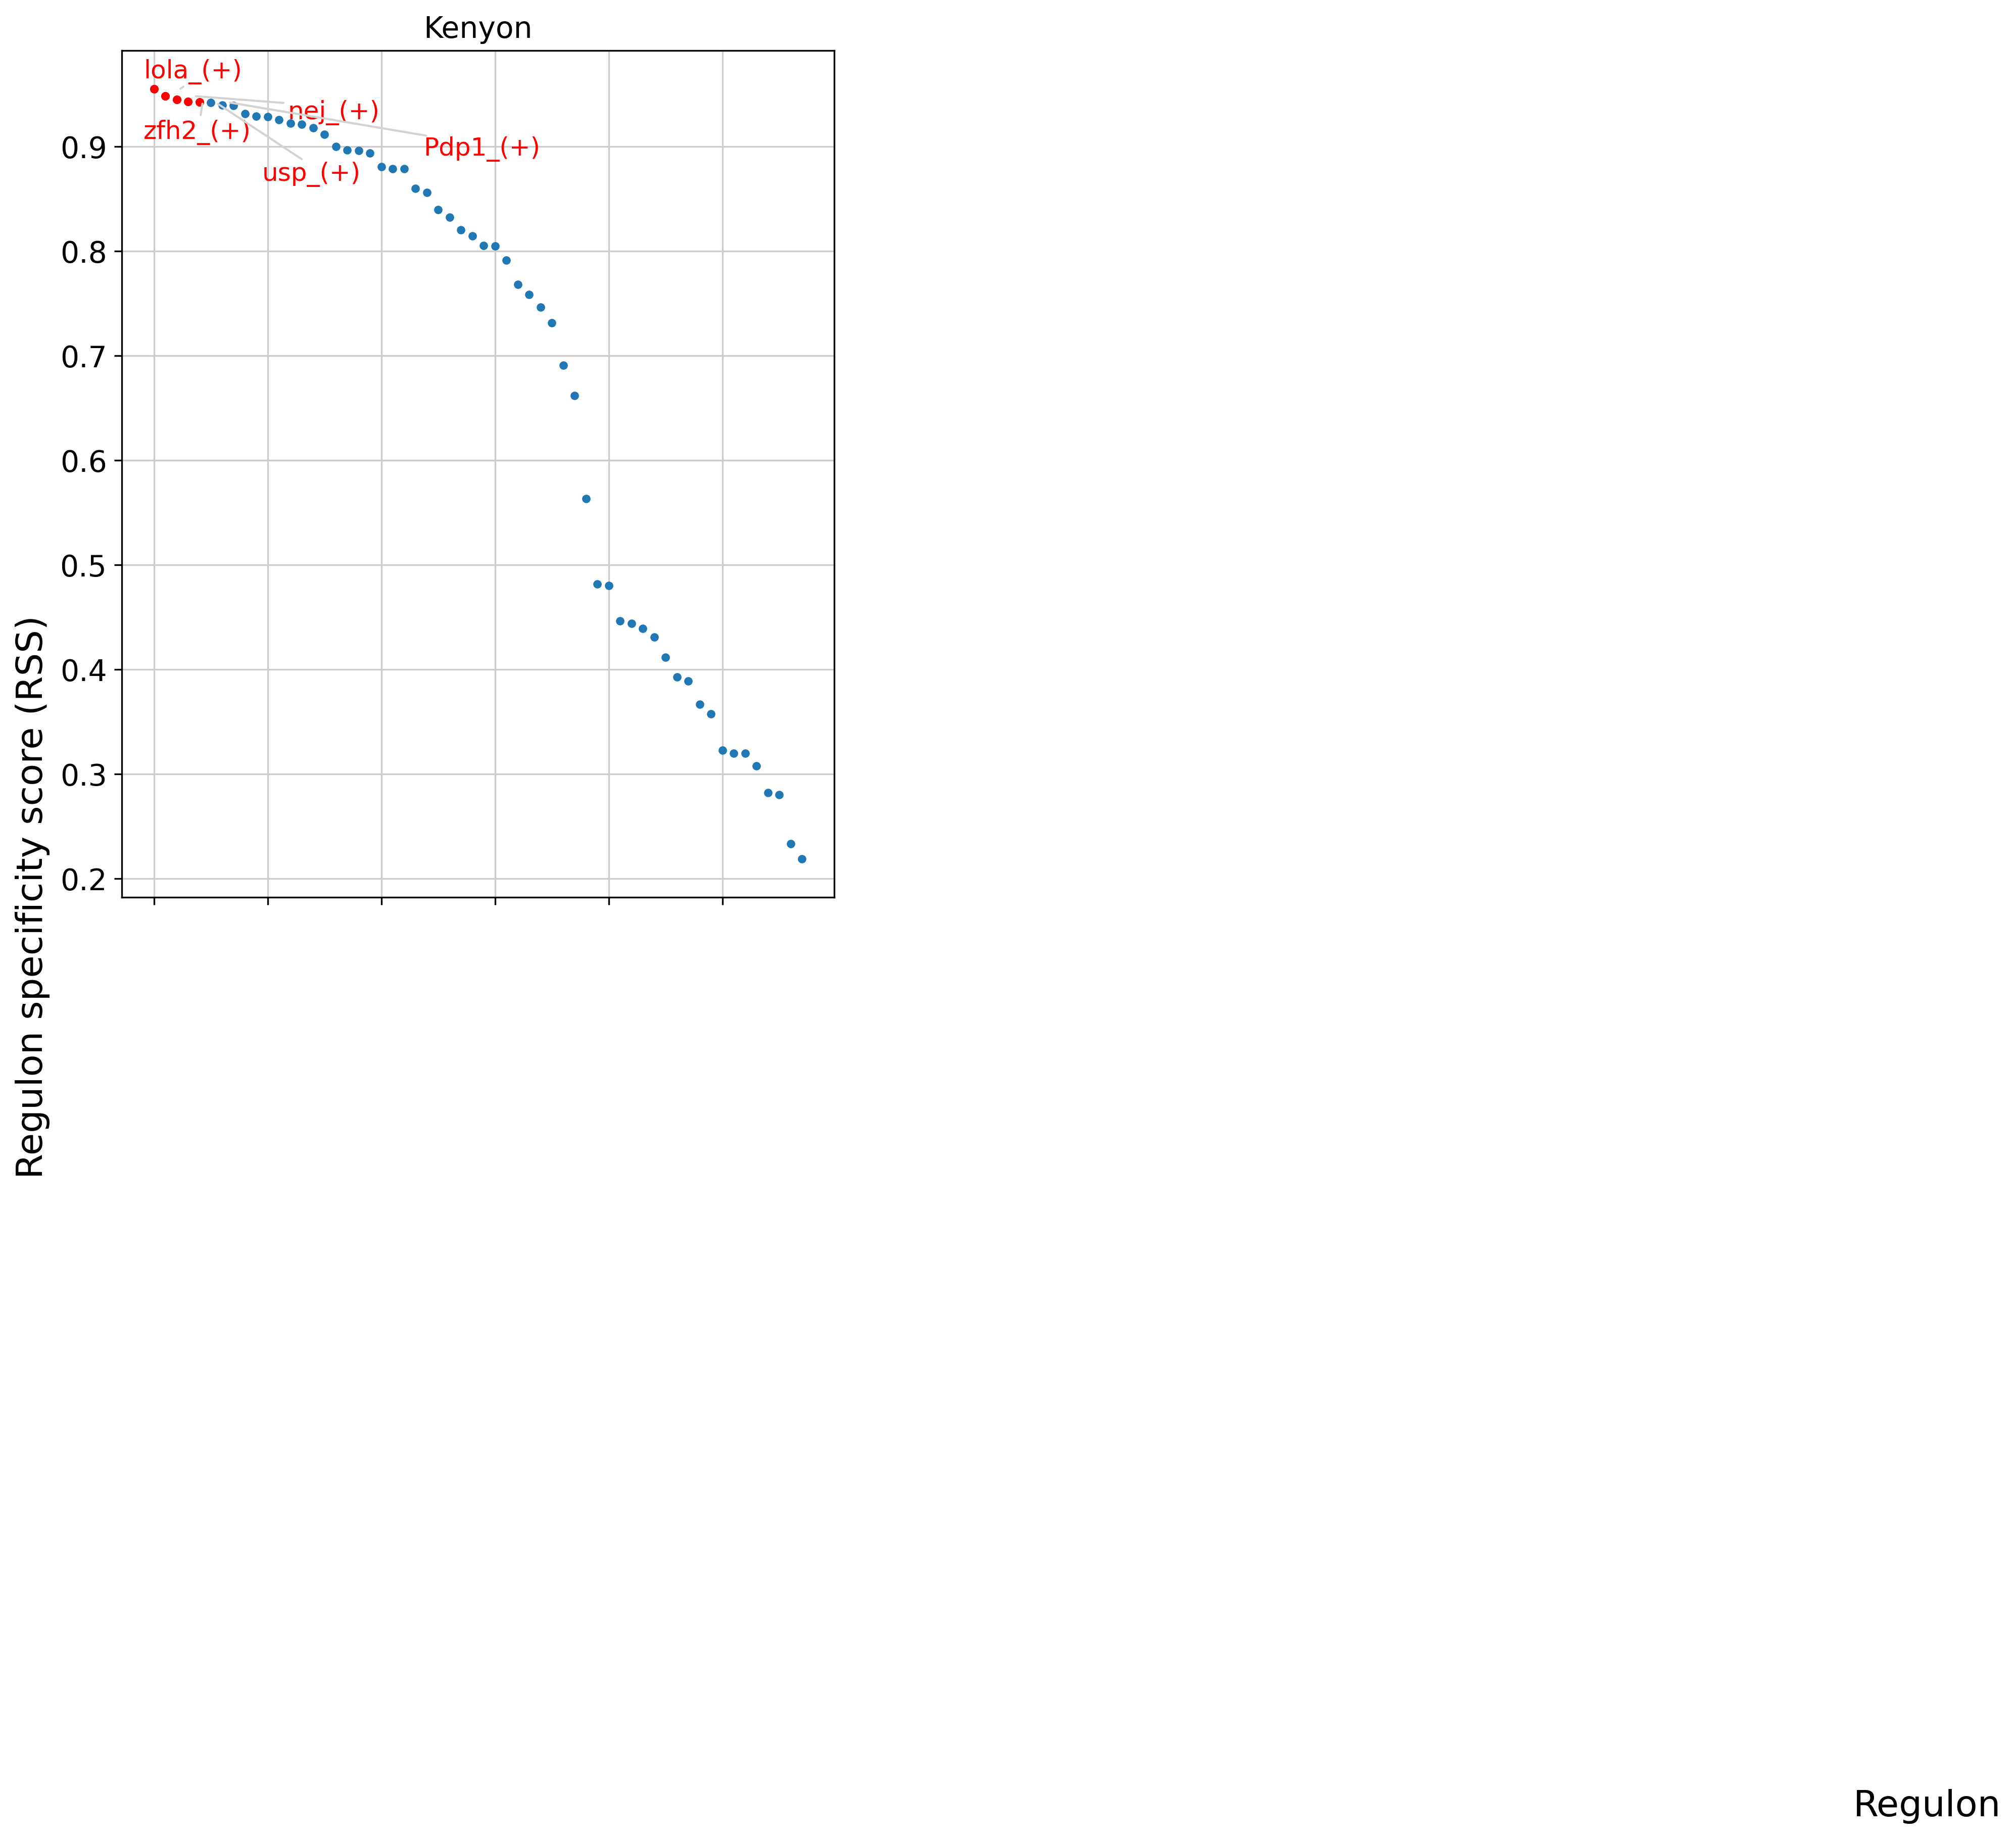

In [16]:
cats = sorted(list(set(cellAnnot['Celltype_Garnett'])))

fig = plt.figure(figsize=(25, 12))
for c,num in zip(cats, range(1,len(cats)+1)):
    x=rss_cellType.T[c]
    ax = fig.add_subplot(2,5,num)
    plot_rss(rss_cellType, c, top_n=5, max_n=None, ax=ax)
    ax.set_ylim( x.min()-(x.max()-x.min())*0.05 , x.max()+(x.max()-x.min())*0.05 )
    for t in ax.texts:
        t.set_fontsize(12)
    ax.set_ylabel('')
    ax.set_xlabel('')
    adjust_text(ax.texts, autoalign='xy', ha='right', va='bottom', arrowprops=dict(arrowstyle='-',color='lightgrey'), precision=0.001 )
 
fig.text(0.5, 0.0, 'Regulon', ha='center', va='center', size='x-large')
fig.text(0.00, 0.5, 'Regulon specificity score (RSS)', ha='center', va='center', rotation='vertical', size='x-large')
plt.tight_layout()
plt.rcParams.update({
    'figure.autolayout': True,
        'figure.titlesize': 'large' ,
        'axes.labelsize': 'medium',
        'axes.titlesize':'large',
        'xtick.labelsize':'medium',
        'ytick.labelsize':'medium'
        })
plt.savefig("Kenyon_cellType-RSS-top5.pdf", dpi=600, bbox_inches = "tight")
plt.show()

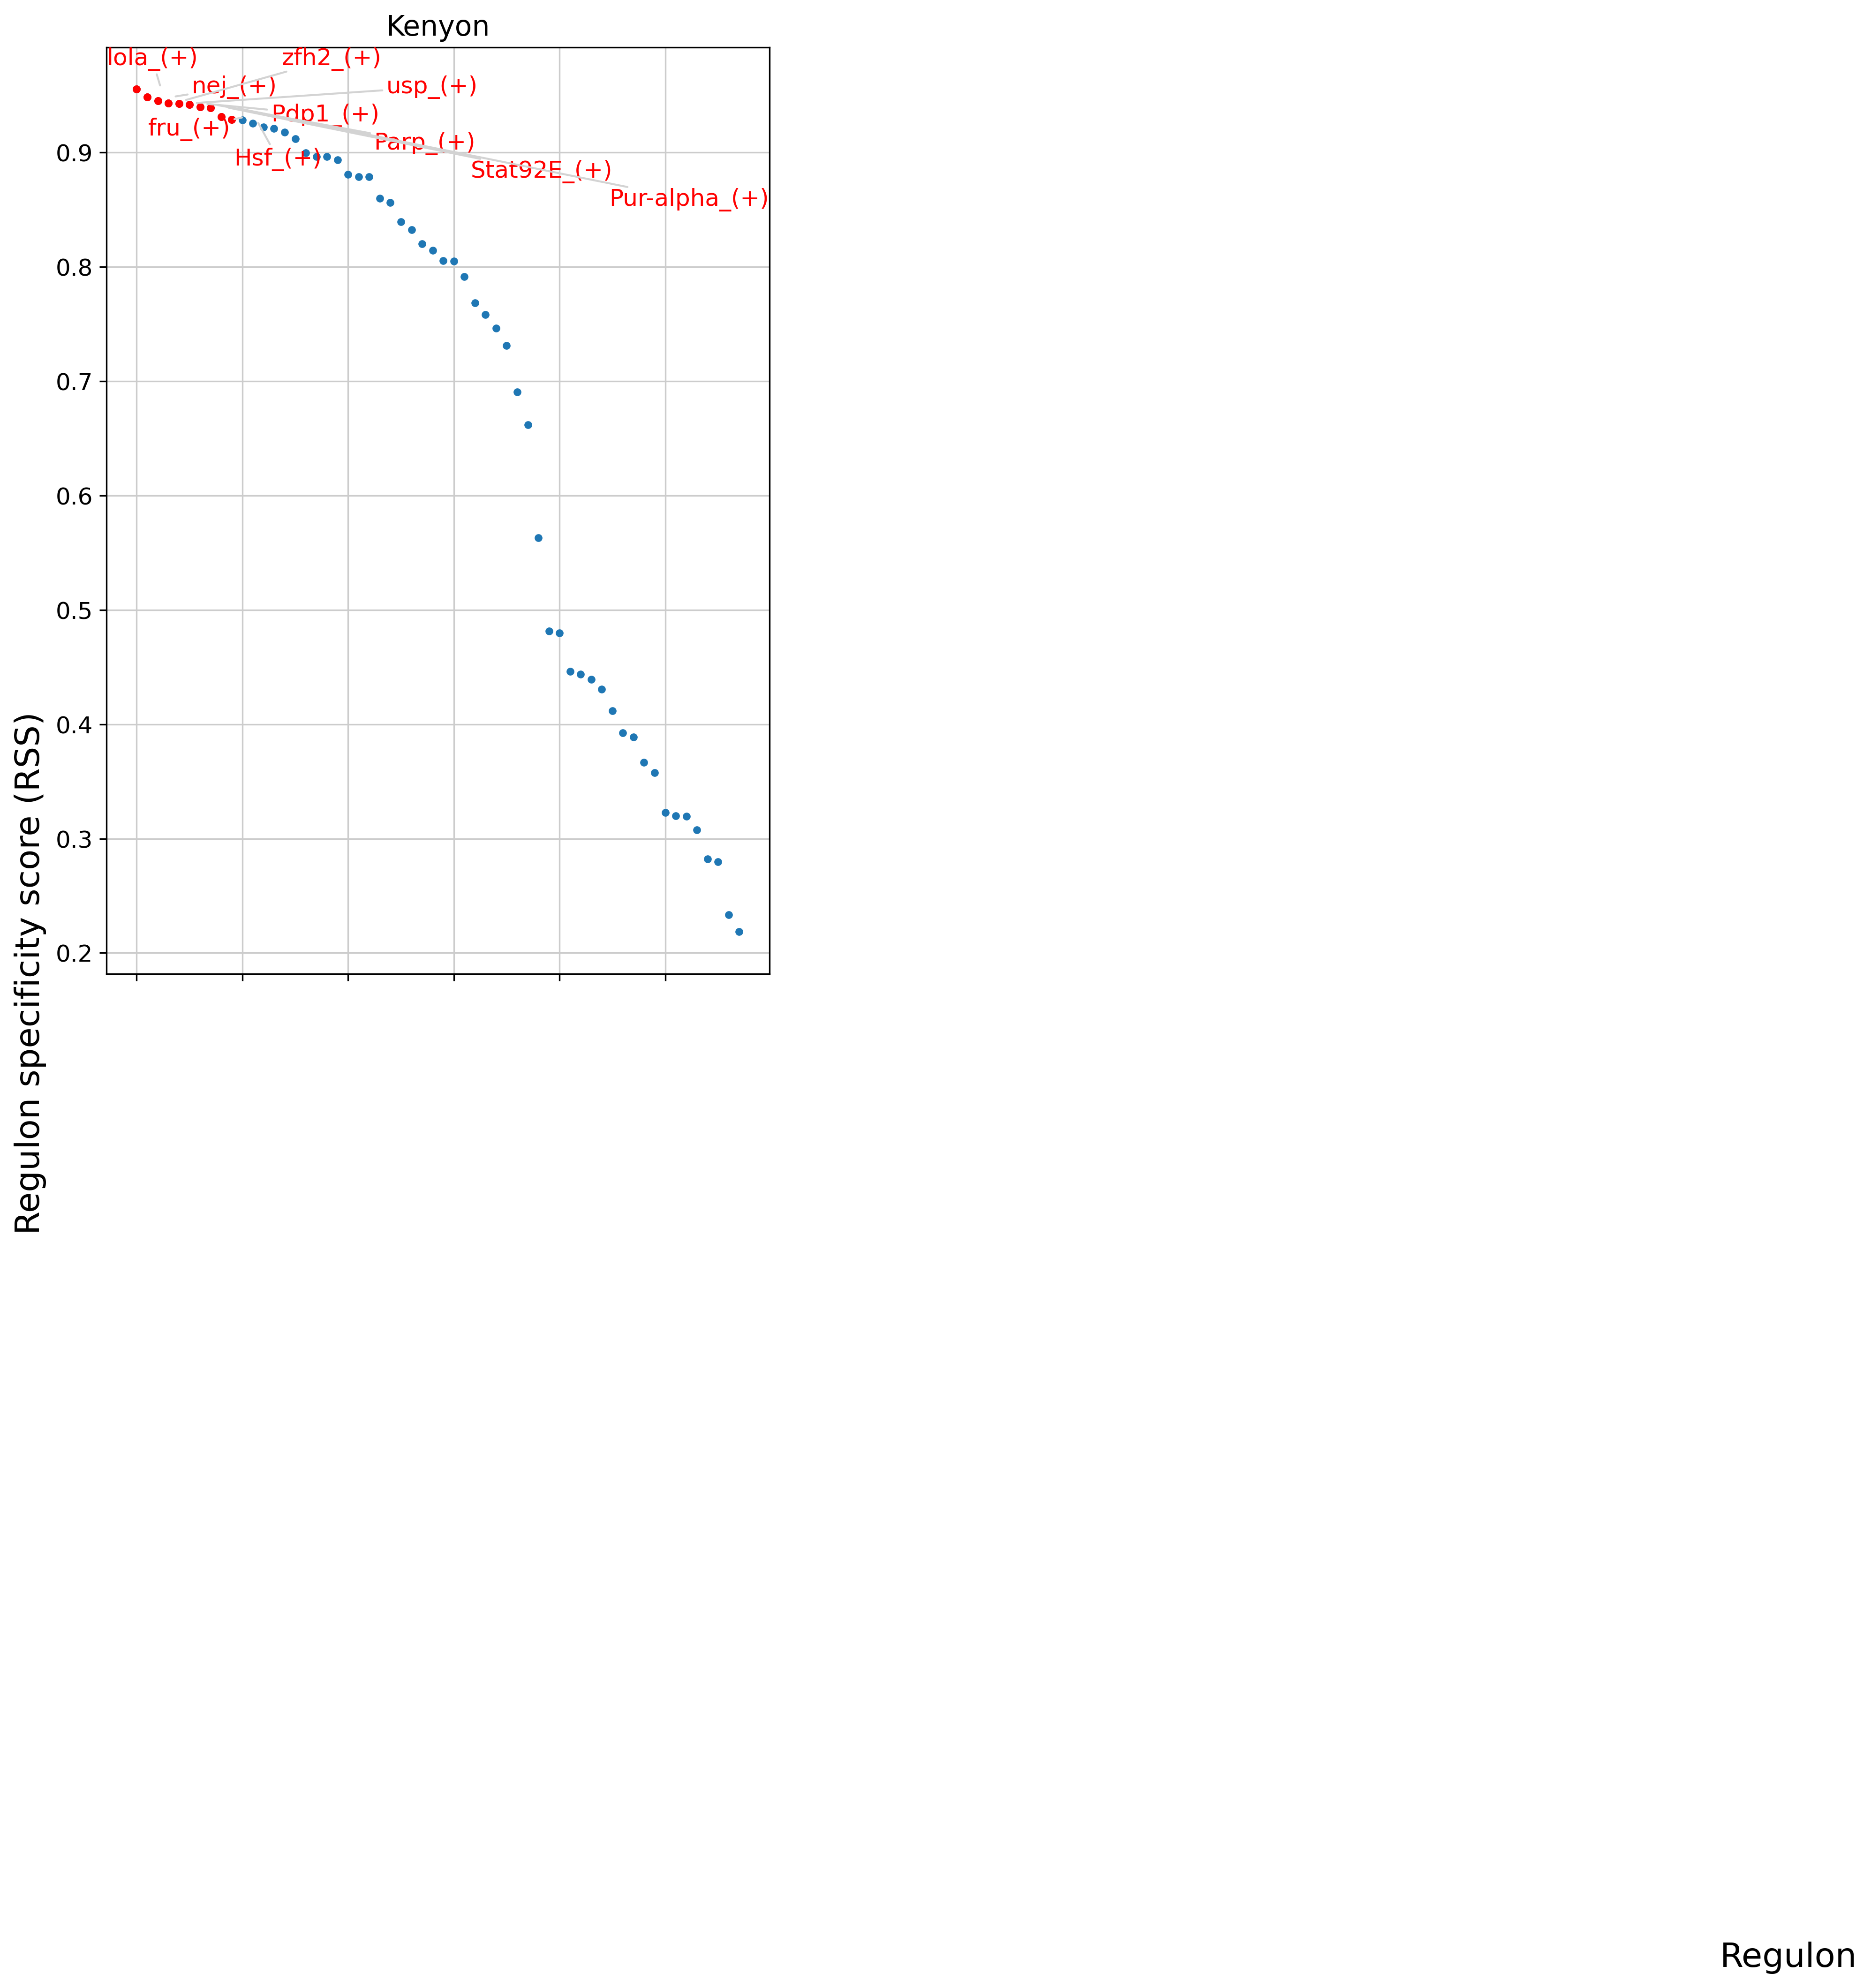

In [17]:
cats = sorted(list(set(cellAnnot['Celltype_Garnett'])))

fig = plt.figure(figsize=(25, 14))
for c,num in zip(cats, range(1,len(cats)+1)):
    x=rss_cellType.T[c]
    ax = fig.add_subplot(2,5,num)
    plot_rss(rss_cellType, c, top_n=10, max_n=None, ax=ax)
    ax.set_ylim( x.min()-(x.max()-x.min())*0.05 , x.max()+(x.max()-x.min())*0.05 )
    for t in ax.texts:
        t.set_fontsize(12)
    ax.set_ylabel('')
    ax.set_xlabel('')
    adjust_text(ax.texts, autoalign='xy', ha='right', va='bottom', arrowprops=dict(arrowstyle='-',color='lightgrey'), precision=0.001 )
 
fig.text(0.5, 0.0, 'Regulon', ha='center', va='center', size='x-large')
fig.text(0.00, 0.5, 'Regulon specificity score (RSS)', ha='center', va='center', rotation='vertical', size='x-large')
plt.tight_layout()
plt.rcParams.update({
    'figure.autolayout': True,
        'figure.titlesize': 'large' ,
        'axes.labelsize': 'medium',
        'axes.titlesize':'large',
        'xtick.labelsize':'medium',
        'ytick.labelsize':'medium'
        })
plt.savefig("Kenyon_cellType-RSS-top10.pdf", dpi=600, bbox_inches = "tight")
plt.show()

In [18]:
# top 1
topreg = []
for i,c in enumerate(cats):
    topreg.extend(
        list(rss_cellType.T[c].sort_values(ascending=False)[:1].index)
    )
topreg = list(set(topreg))

In [19]:
# generate Z - Score
auc_mtx_Z = pd.DataFrame( index=auc_mtx.index )
for col in list(auc_mtx.columns):
    auc_mtx_Z[ col ] = ( auc_mtx[col] - auc_mtx[col].mean()) / auc_mtx[col].std(ddof=0)
#auc_mtx_Z.sort_index(inplace=True)

In [20]:
# Generate Heat Map 
def palplot(pal, names, colors=None, size=1):
    n = len(pal)
    f, ax = plt.subplots(1, 1, figsize=(n * size, size))
    ax.imshow(np.arange(n).reshape(1, n),
              cmap=mpl.colors.ListedColormap(list(pal)),
              interpolation="nearest", aspect="auto")
    ax.set_xticks(np.arange(n) - .5)
    ax.set_yticks([-.5, .5])
    ax.set_xticklabels([])
    ax.set_yticklabels([])
    colors = n * ['k'] if colors is None else colors
    for idx, (name, color) in enumerate(zip(names, colors)):
        ax.text(0.0+idx, 0.0, name, color=color, horizontalalignment='center', verticalalignment='center')
    return f

In [21]:
colors = sns.color_palette('bright',n_colors=len(cats) )
colorsd = dict( zip( cats, colors ))
colormap = [ colorsd[x] for x in cellAnnot['Celltype_Garnett'] ]

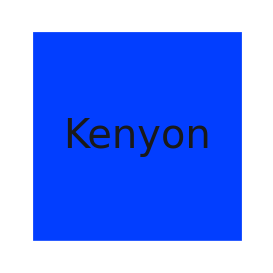

In [22]:

sns.set()
sns.set(font_scale=0.8)
fig = palplot( colors, cats, size=1.0)
plt.savefig("Kenyon_Control_cellType-heatmap-legend-top1.pdf", dpi=600, bbox_inches = "tight")

In [23]:
# top 5
topreg = []
for i,c in enumerate(cats):
    topreg.extend(
        list(rss_cellType.T[c].sort_values(ascending=False)[:5].index)
    )
topreg = list(set(topreg))

In [24]:
# generate Z - Score
auc_mtx_Z = pd.DataFrame( index=auc_mtx.index )
for col in list(auc_mtx.columns):
    auc_mtx_Z[ col ] = ( auc_mtx[col] - auc_mtx[col].mean()) / auc_mtx[col].std(ddof=0)
#auc_mtx_Z.sort_index(inplace=True)

In [25]:
# Generate Heat Map 
def palplot(pal, names, colors=None, size=1):
    n = len(pal)
    f, ax = plt.subplots(1, 1, figsize=(n * size, size))
    ax.imshow(np.arange(n).reshape(1, n),
              cmap=mpl.colors.ListedColormap(list(pal)),
              interpolation="nearest", aspect="auto")
    ax.set_xticks(np.arange(n) - .5)
    ax.set_yticks([-.5, .5])
    ax.set_xticklabels([])
    ax.set_yticklabels([])
    colors = n * ['k'] if colors is None else colors
    for idx, (name, color) in enumerate(zip(names, colors)):
        ax.text(0.0+idx, 0.0, name, color=color, horizontalalignment='center', verticalalignment='center')
    return f

    

In [26]:
colors = sns.color_palette('bright',n_colors=len(cats) )
colorsd = dict( zip( cats, colors ))
colormap = [ colorsd[x] for x in cellAnnot['Celltype_Garnett'] ]

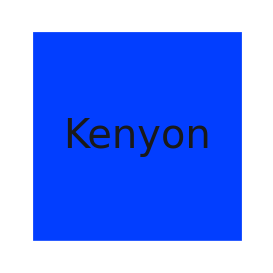

In [27]:

sns.set()
sns.set(font_scale=0.8)
fig = palplot( colors, cats, size=1.0)
plt.savefig("Kenyon_Mutant_cellType-heatmap-legend-top5.pdf", dpi=600, bbox_inches = "tight")

/home/acicalo/miniconda3/envs/pyscenic/lib/python3.10/site-packages/seaborn/matrix.py:560: UserWarning: Clustering large matrix with scipy. Installing `fastcluster` may give better performance.
  warnings.warn(msg)


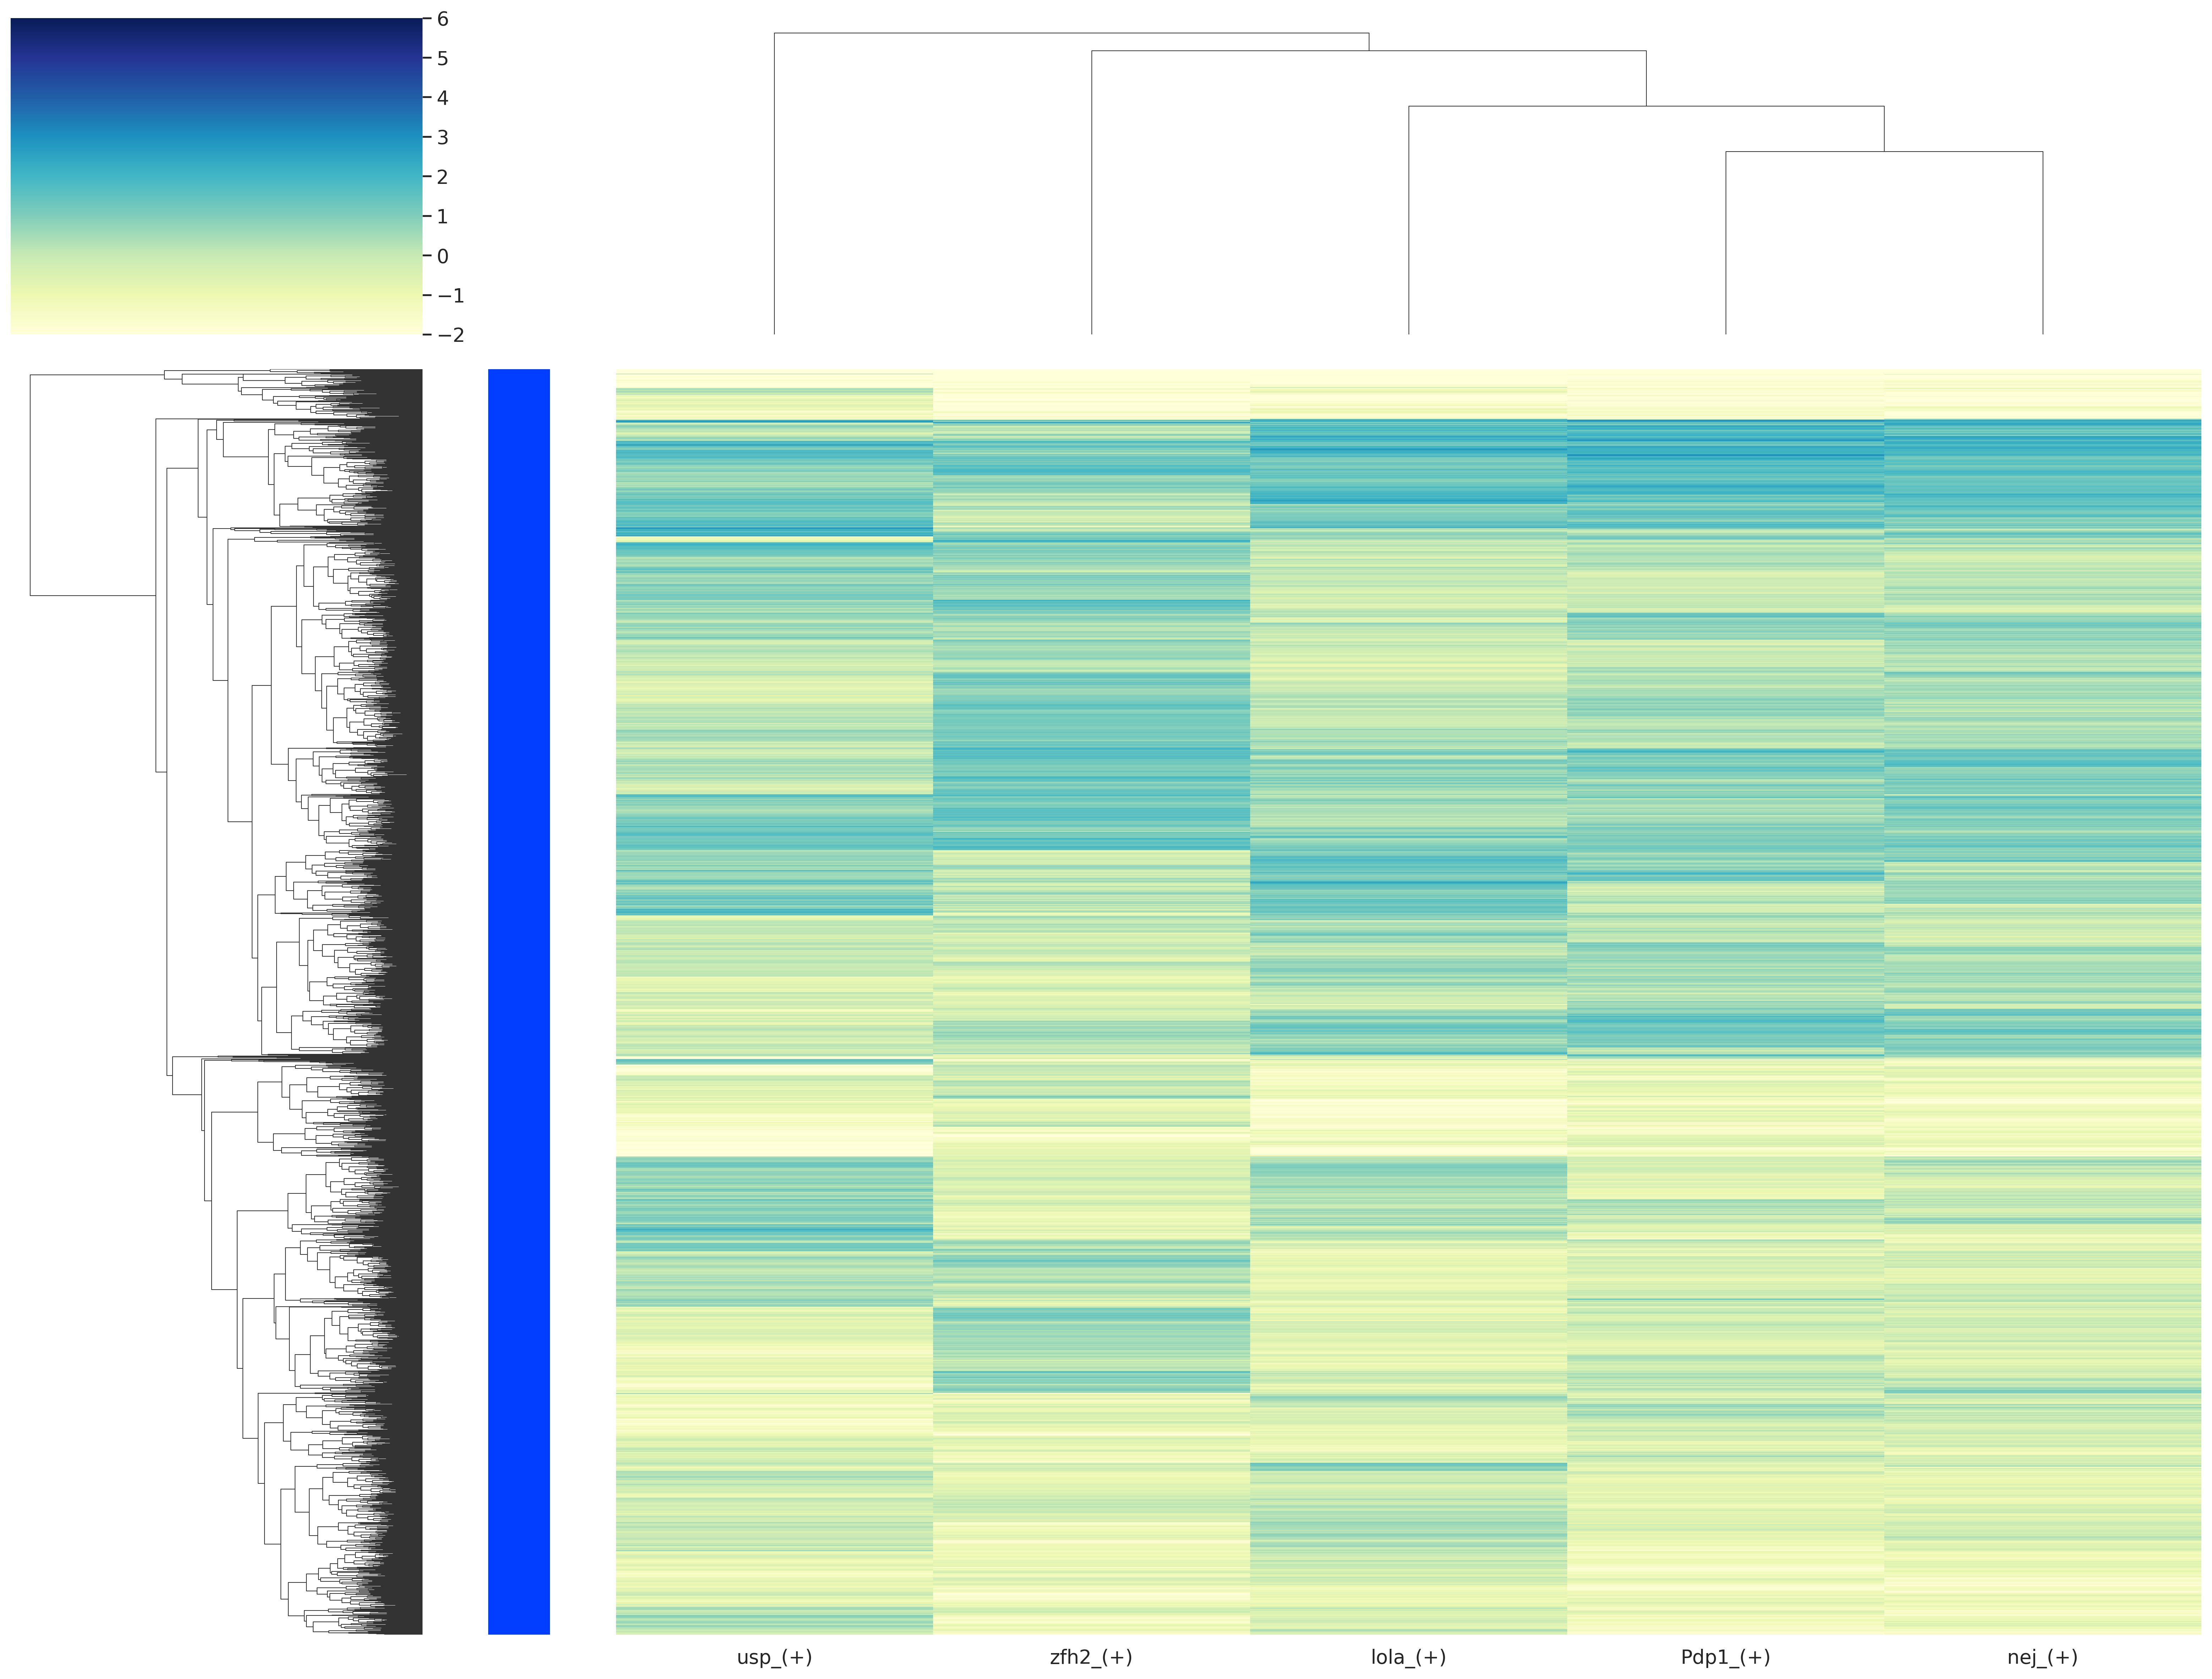

In [28]:
sns.set(font_scale=1.2)
g = sns.clustermap(auc_mtx_Z[topreg], annot=False,  square=False,  linecolor='gray',
    yticklabels=False, xticklabels=True, vmin=-2, vmax=6, row_colors=colormap,
    cmap="YlGnBu", figsize=(21,16) )
g.cax.set_visible(True)
g.ax_heatmap.set_ylabel('')
g.ax_heatmap.set_xlabel('')
plt.savefig("Kenyon_Mutant_cellType-heatmap-top5.pdf", dpi=600, bbox_inches = "tight")

In [29]:
# top 10
topreg = []
for i,c in enumerate(cats):
    topreg.extend(
        list(rss_cellType.T[c].sort_values(ascending=False)[:10].index)
    )
topreg = list(set(topreg))

In [30]:
# generate Z - Score
auc_mtx_Z = pd.DataFrame( index=auc_mtx.index )
for col in list(auc_mtx.columns):
    auc_mtx_Z[ col ] = ( auc_mtx[col] - auc_mtx[col].mean()) / auc_mtx[col].std(ddof=0)
#auc_mtx_Z.sort_index(inplace=True)

In [31]:
# Generate Heat Map 
def palplot(pal, names, colors=None, size=1):
    n = len(pal)
    f, ax = plt.subplots(1, 1, figsize=(n * size, size))
    ax.imshow(np.arange(n).reshape(1, n),
              cmap=mpl.colors.ListedColormap(list(pal)),
              interpolation="nearest", aspect="auto")
    ax.set_xticks(np.arange(n) - .5)
    ax.set_yticks([-.5, .5])
    ax.set_xticklabels([])
    ax.set_yticklabels([])
    colors = n * ['k'] if colors is None else colors
    for idx, (name, color) in enumerate(zip(names, colors)):
        ax.text(0.0+idx, 0.0, name, color=color, horizontalalignment='center', verticalalignment='center')
    return f

In [32]:
colors = sns.color_palette('bright',n_colors=len(cats) )
colorsd = dict( zip( cats, colors ))
colormap = [ colorsd[x] for x in cellAnnot['Celltype_Garnett'] ]

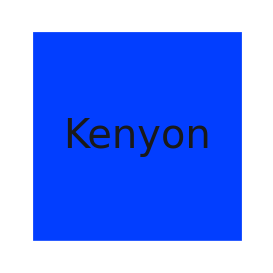

In [33]:

sns.set()
sns.set(font_scale=0.8)
fig = palplot( colors, cats, size=1.0)
plt.savefig("Kenyon_Mutant_cellType-heatmap-legend-top10.pdf", dpi=600, bbox_inches = "tight")

/home/acicalo/miniconda3/envs/pyscenic/lib/python3.10/site-packages/seaborn/matrix.py:560: UserWarning: Clustering large matrix with scipy. Installing `fastcluster` may give better performance.
  warnings.warn(msg)


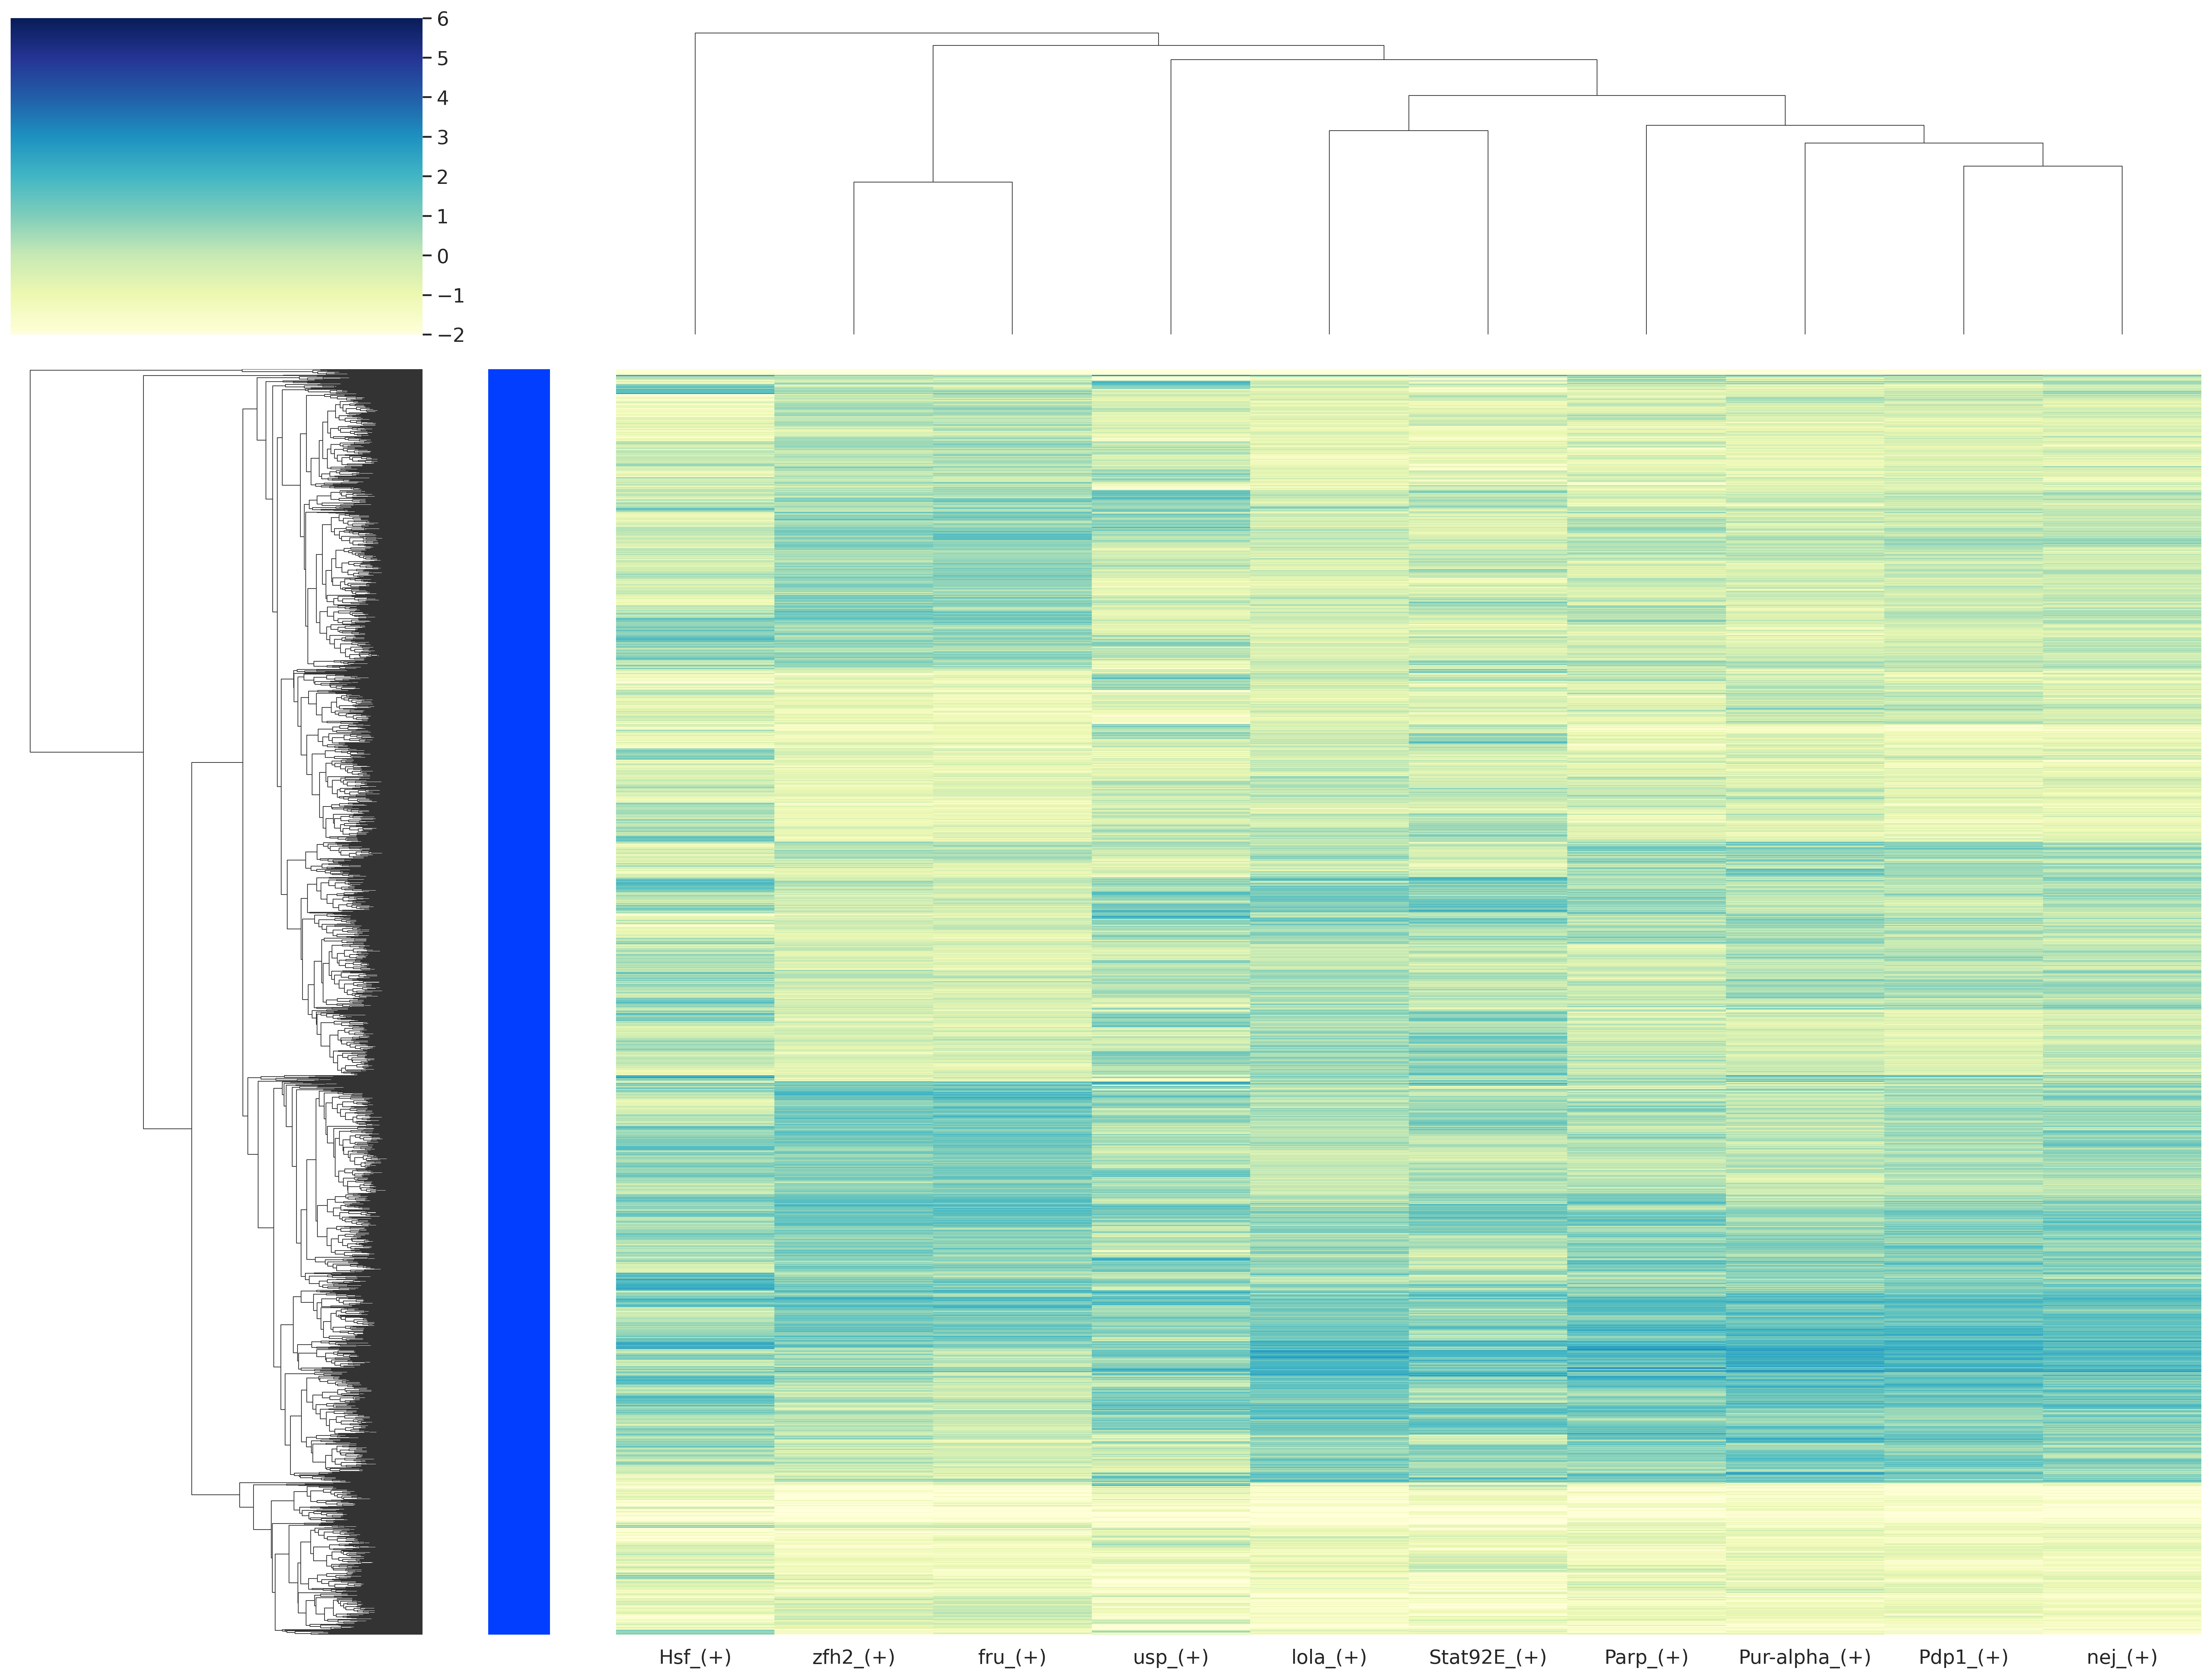

In [34]:
sns.set(font_scale=1.2)
g = sns.clustermap(auc_mtx_Z[topreg], annot=False,  square=False,  linecolor='gray',
    yticklabels=False, xticklabels=True, vmin=-2, vmax=6, row_colors=colormap,
    cmap="YlGnBu", figsize=(21,16) )
g.cax.set_visible(True)
g.ax_heatmap.set_ylabel('')
g.ax_heatmap.set_xlabel('')
plt.savefig("Kenyon_Mutant_cellType-heatmap-top10.pdf", dpi=600, bbox_inches = "tight")

In [35]:
auc_mtx

BEAF-32_(+)  Blimp-1_(+)  BtbVII_(+)  CG5641_(+)  \
AAACCCAAGCCGTAAG-1_3     0.100569     0.140977    0.151261    0.083220   
AAACCCAAGGAACGCT-1_3     0.083333     0.165402    0.017620    0.254812   
AAACCCAGTATGTCTG-1_3     0.128611     0.136501    0.227704    0.100840   
AAACCCAGTTTATGCG-1_3     0.072791     0.178052    0.217674    0.215506   
AAACCCATCTTCCACG-1_3     0.086865     0.135795    0.168880    0.128219   
...                           ...          ...         ...         ...   
TTTATGCGTCCCGGTA-1_6     0.157390     0.150538    0.249932    0.121984   
TTTCACAGTAGTTCCA-1_6     0.087866     0.141512    0.102738    0.120900   
TTTCCTCTCTCTGAGA-1_6     0.156441     0.170875    0.136622    0.066414   
TTTGATCAGCGGTAGT-1_6     0.080540     0.174354    0.231770    0.015722   
TTTGGAGAGGCAGCTA-1_6     0.080645     0.137060    0.264028    0.000000   

                      CG8319_(+)  Cdc5_(+)     D_(+)  E_(bx)_(+)  \
AAACCCAAGCCGTAAG-1_3    0.033496  0.093264  0.010626    0.269450   
AAACCCAAGGAACGCT-1_3    0.044881  0.257970  0.035579    0.121713   
AAACCCAGTATGTCTG-1_3    0.039683  0.153131  0.000000    0.335863   
AAACCCAGTTTATGCG-1_3    0.041251  0.271157  0.000000    0.308620   
AAACCCATCTTCCACG-1_3    0.063856  0.185958  0.032448    0.418813   
...                          ...       ...       ...         ...   
TTTATGCGTCCCGGTA-1_6    0.000000  0.100949  0.000000    0.213472   
TTTCACAGTAGTTCCA-1_6    0.009488  0.134725  0.013662    0.254812   
TTTCCTCTCTCTGAGA-1_6    0.056018  0.183017  0.000000    0.381811   
TTTGATCAGCGGTAGT-1_6    0.041746  0.169829  0.000000    0.287476   
TTTGGAGAGGCAGCTA-1_6    0.025740  0.138330  0.000000    0.243291   

                      E_(spl)mgamma-HLH_(+)   ERR_(+)  ...    oc_(+)  \
AAACCCAAGCCGTAAG-1_3                    0.0  0.000000  ...  0.000000   
AAACCCAAGGAACGCT-1_3                    0.0  0.000000  ...  0.000000   
AAACCCAGTATGTCTG-1_3                    0.0  0.095509  ...  0.000000   
AAACCCAGTTTATGCG-1_3                    0.0  0.000000  ...  0.000000   
AAACCCATCTTCCACG-1_3                    0.0  0.000000  ...  0.000000   
...                                     ...       ...  ...       ...   
TTTATGCGTCCCGGTA-1_6                    0.0  0.000000  ...  0.007590   
TTTCACAGTAGTTCCA-1_6                    0.0  0.047438  ...  0.120683   
TTTCCTCTCTCTGAGA-1_6                    0.0  0.078748  ...  0.000000   
TTTGATCAGCGGTAGT-1_6                    0.0  0.000000  ...  0.000000   
TTTGGAGAGGCAGCTA-1_6                    0.0  0.000000  ...  0.000000   

                       pho_(+)  scro_(+)   sim_(+)  so_(+)   srp_(+)  \
AAACCCAAGCCGTAAG-1_3  0.079834  0.146913  0.000000     0.0  0.000000   
AAACCCAAGGAACGCT-1_3  0.099586  0.066925  0.007827     0.0  0.000723   
AAACCCAGTATGTCTG-1_3  0.066207  0.037878  0.000000     0.0  0.000000   
AAACCCAGTTTATGCG-1_3  0.112437  0.087724  0.074715     0.0  0.002259   
AAACCCATCTTCCACG-1_3  0.136588  0.157276  0.062619     0.0  0.000000   
...                        ...       ...       ...     ...       ...   
TTTATGCGTCCCGGTA-1_6  0.093393  0.071887  0.000000     0.0  0.000000   
TTTCACAGTAGTTCCA-1_6  0.098706  0.077945  0.000000     0.0  0.000000   
TTTCCTCTCTCTGAGA-1_6  0.085924  0.061743  0.000000     0.0  0.000000   
TTTGATCAGCGGTAGT-1_6  0.061911  0.099548  0.000000     0.0  0.009668   
TTTGGAGAGGCAGCTA-1_6  0.101380  0.037659  0.000000     0.0  0.000000   

                        tj_(+)   usp_(+)   vvl_(+)  zfh2_(+)  
AAACCCAAGCCGTAAG-1_3  0.000000  0.156072  0.000000  0.136662  
AAACCCAAGGAACGCT-1_3  0.018975  0.122015  0.031626  0.149809  
AAACCCAGTATGTCTG-1_3  0.047000  0.173264  0.000000  0.172597  
AAACCCAGTTTATGCG-1_3  0.036929  0.121720  0.000000  0.184151  
AAACCCATCTTCCACG-1_3  0.021749  0.151623  0.000000  0.169511  
...                        ...       ...       ...       ...  
TTTATGCGTCCCGGTA-1_6  0.044519  0.108879  0.000000  0.118311  
TTTCACAGTAGTTCCA-1_6  0.000000  0.128689  0.000000  0.142202  
TTTCCTCTCTCTGAGA-1_

In [36]:
# Generate a binary regulon activity matrix
binary_mtx, auc_thresholds = binarize( auc_mtx, num_workers=50 )
binary_mtx.head()

BEAF-32_(+)  Blimp-1_(+)  BtbVII_(+)  CG5641_(+)  \
AAACCCAAGCCGTAAG-1_3            0            0           0           0   
AAACCCAAGGAACGCT-1_3            0            0           0           1   
AAACCCAGTATGTCTG-1_3            0            0           0           0   
AAACCCAGTTTATGCG-1_3            0            0           0           1   
AAACCCATCTTCCACG-1_3            0            0           0           0   

                      CG8319_(+)  Cdc5_(+)  D_(+)  E_(bx)_(+)  \
AAACCCAAGCCGTAAG-1_3           1         0      0           0   
AAACCCAAGGAACGCT-1_3           1         0      1           0   
AAACCCAGTATGTCTG-1_3           1         0      0           0   
AAACCCAGTTTATGCG-1_3           1         0      0           0   
AAACCCATCTTCCACG-1_3           1         0      1           0   

                      E_(spl)mgamma-HLH_(+)  ERR_(+)  ...  oc_(+)  pho_(+)  \
AAACCCAAGCCGTAAG-1_3                      0        0  ...       0        0   
AAACCCAAGGAACGCT-1_3                      0        0  ...       0        0   
AAACCCAGTATGTCTG-1_3                      0        1  ...       0        0   
AAACCCAGTTTATGCG-1_3                      0        0  ...       0        0   
AAACCCATCTTCCACG-1_3                      0        0  ...       0        0   

                      scro_(+)  sim_(+)  so_(+)  srp_(+)  tj_(+)  usp_(+)  \
AAACCCAAGCCGTAAG-1_3         0        0       0        0       0        0   
AAACCCAAGGAACGCT-1_3         0        0       0        0       0        0   
AAACCCAGTATGTCTG-1_3         0        0       0        0       1        0   
AAACCCAGTTTATGCG-1_3         0        1       0        0       0        0   
AAACCCATCTTCCACG-1_3         0        1       0        0       0        0   

                      vvl_(+)  zfh2_(+)  
AAACCCAAGCCGTAAG-1_3        0         0  
AAACCCAAGGAACGCT-1_3        0         0  
AAACCCAGTATGTCTG-1_3        0         0  
AAACCCAGTTTATGCG-1_3        0         0  
AAACCCATCTTCCACG-1_3        0         0  

[5 rows x 58 columns]

In [37]:
auc_mtx

BEAF-32_(+)  Blimp-1_(+)  BtbVII_(+)  CG5641_(+)  \
AAACCCAAGCCGTAAG-1_3     0.100569     0.140977    0.151261    0.083220   
AAACCCAAGGAACGCT-1_3     0.083333     0.165402    0.017620    0.254812   
AAACCCAGTATGTCTG-1_3     0.128611     0.136501    0.227704    0.100840   
AAACCCAGTTTATGCG-1_3     0.072791     0.178052    0.217674    0.215506   
AAACCCATCTTCCACG-1_3     0.086865     0.135795    0.168880    0.128219   
...                           ...          ...         ...         ...   
TTTATGCGTCCCGGTA-1_6     0.157390     0.150538    0.249932    0.121984   
TTTCACAGTAGTTCCA-1_6     0.087866     0.141512    0.102738    0.120900   
TTTCCTCTCTCTGAGA-1_6     0.156441     0.170875    0.136622    0.066414   
TTTGATCAGCGGTAGT-1_6     0.080540     0.174354    0.231770    0.015722   
TTTGGAGAGGCAGCTA-1_6     0.080645     0.137060    0.264028    0.000000   

                      CG8319_(+)  Cdc5_(+)     D_(+)  E_(bx)_(+)  \
AAACCCAAGCCGTAAG-1_3    0.033496  0.093264  0.010626    0.269450   
AAACCCAAGGAACGCT-1_3    0.044881  0.257970  0.035579    0.121713   
AAACCCAGTATGTCTG-1_3    0.039683  0.153131  0.000000    0.335863   
AAACCCAGTTTATGCG-1_3    0.041251  0.271157  0.000000    0.308620   
AAACCCATCTTCCACG-1_3    0.063856  0.185958  0.032448    0.418813   
...                          ...       ...       ...         ...   
TTTATGCGTCCCGGTA-1_6    0.000000  0.100949  0.000000    0.213472   
TTTCACAGTAGTTCCA-1_6    0.009488  0.134725  0.013662    0.254812   
TTTCCTCTCTCTGAGA-1_6    0.056018  0.183017  0.000000    0.381811   
TTTGATCAGCGGTAGT-1_6    0.041746  0.169829  0.000000    0.287476   
TTTGGAGAGGCAGCTA-1_6    0.025740  0.138330  0.000000    0.243291   

                      E_(spl)mgamma-HLH_(+)   ERR_(+)  ...    oc_(+)  \
AAACCCAAGCCGTAAG-1_3                    0.0  0.000000  ...  0.000000   
AAACCCAAGGAACGCT-1_3                    0.0  0.000000  ...  0.000000   
AAACCCAGTATGTCTG-1_3                    0.0  0.095509  ...  0.000000   
AAACCCAGTTTATGCG-1_3                    0.0  0.000000  ...  0.000000   
AAACCCATCTTCCACG-1_3                    0.0  0.000000  ...  0.000000   
...                                     ...       ...  ...       ...   
TTTATGCGTCCCGGTA-1_6                    0.0  0.000000  ...  0.007590   
TTTCACAGTAGTTCCA-1_6                    0.0  0.047438  ...  0.120683   
TTTCCTCTCTCTGAGA-1_6                    0.0  0.078748  ...  0.000000   
TTTGATCAGCGGTAGT-1_6                    0.0  0.000000  ...  0.000000   
TTTGGAGAGGCAGCTA-1_6                    0.0  0.000000  ...  0.000000   

                       pho_(+)  scro_(+)   sim_(+)  so_(+)   srp_(+)  \
AAACCCAAGCCGTAAG-1_3  0.079834  0.146913  0.000000     0.0  0.000000   
AAACCCAAGGAACGCT-1_3  0.099586  0.066925  0.007827     0.0  0.000723   
AAACCCAGTATGTCTG-1_3  0.066207  0.037878  0.000000     0.0  0.000000   
AAACCCAGTTTATGCG-1_3  0.112437  0.087724  0.074715     0.0  0.002259   
AAACCCATCTTCCACG-1_3  0.136588  0.157276  0.062619     0.0  0.000000   
...                        ...       ...       ...     ...       ...   
TTTATGCGTCCCGGTA-1_6  0.093393  0.071887  0.000000     0.0  0.000000   
TTTCACAGTAGTTCCA-1_6  0.098706  0.077945  0.000000     0.0  0.000000   
TTTCCTCTCTCTGAGA-1_6  0.085924  0.061743  0.000000     0.0  0.000000   
TTTGATCAGCGGTAGT-1_6  0.061911  0.099548  0.000000     0.0  0.009668   
TTTGGAGAGGCAGCTA-1_6  0.101380  0.037659  0.000000     0.0  0.000000   

                        tj_(+)   usp_(+)   vvl_(+)  zfh2_(+)  
AAACCCAAGCCGTAAG-1_3  0.000000  0.156072  0.000000  0.136662  
AAACCCAAGGAACGCT-1_3  0.018975  0.122015  0.031626  0.149809  
AAACCCAGTATGTCTG-1_3  0.047000  0.173264  0.000000  0.172597  
AAACCCAGTTTATGCG-1_3  0.036929  0.121720  0.000000  0.184151  
AAACCCATCTTCCACG-1_3  0.021749  0.151623  0.000000  0.169511  
...                        ...       ...       ...       ...  
TTTATGCGTCCCGGTA-1_6  0.044519  0.108879  0.000000  0.118311  
TTTCACAGTAGTTCCA-1_6  0.000000  0.128689  0.000000  0.142202  
TTTCCTCTCTCTGAGA-1_

In [38]:
auc_thresholds.to_csv('auc_threshold.csv')
auc_mtx.to_csv('auc_mtx.csv')

In [39]:
auc_thresholds

BEAF-32_(+)              0.156676
Blimp-1_(+)              0.234201
BtbVII_(+)               0.356860
CG5641_(+)               0.189534
CG8319_(+)               0.017085
Cdc5_(+)                 0.296585
D_(+)                    0.013825
E_(bx)_(+)               0.429377
E_(spl)mgamma-HLH_(+)    0.034225
ERR_(+)                  0.049736
Eip74EF_(+)              0.122750
Ets65A_(+)               0.125155
H15_(+)                  0.041987
Hr51_(+)                 0.239747
Hr78_(+)                 0.046854
Hsf_(+)                  0.161016
Jra_(+)                  0.058022
Max_(+)                  0.194015
Mitf_(+)                 0.122898
NELF-B_(+)               0.057681
NK7.1_(+)                0.159240
Nf-YA_(+)                0.228111
Parp_(+)                 0.172104
Pdp1_(+)                 0.204594
Pur-alpha_(+)            0.200550
Rel_(+)                  0.013756
Rx_(+)                   0.034852
Sox14_(+)                0.008758
SoxN_(+)                 0.161548
Sry-delta_(+) 

/tmp/ipykernel_15839/4222572171.py:6: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(auc_mtx[ r[i] ], ax=ax, norm_hist=True, bins=100)
/tmp/ipykernel_15839/4222572171.py:6: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(auc_mtx[ r[i] ], ax=ax, norm_hist=True, bins=100)
/tmp/ipykernel_15839/4222572

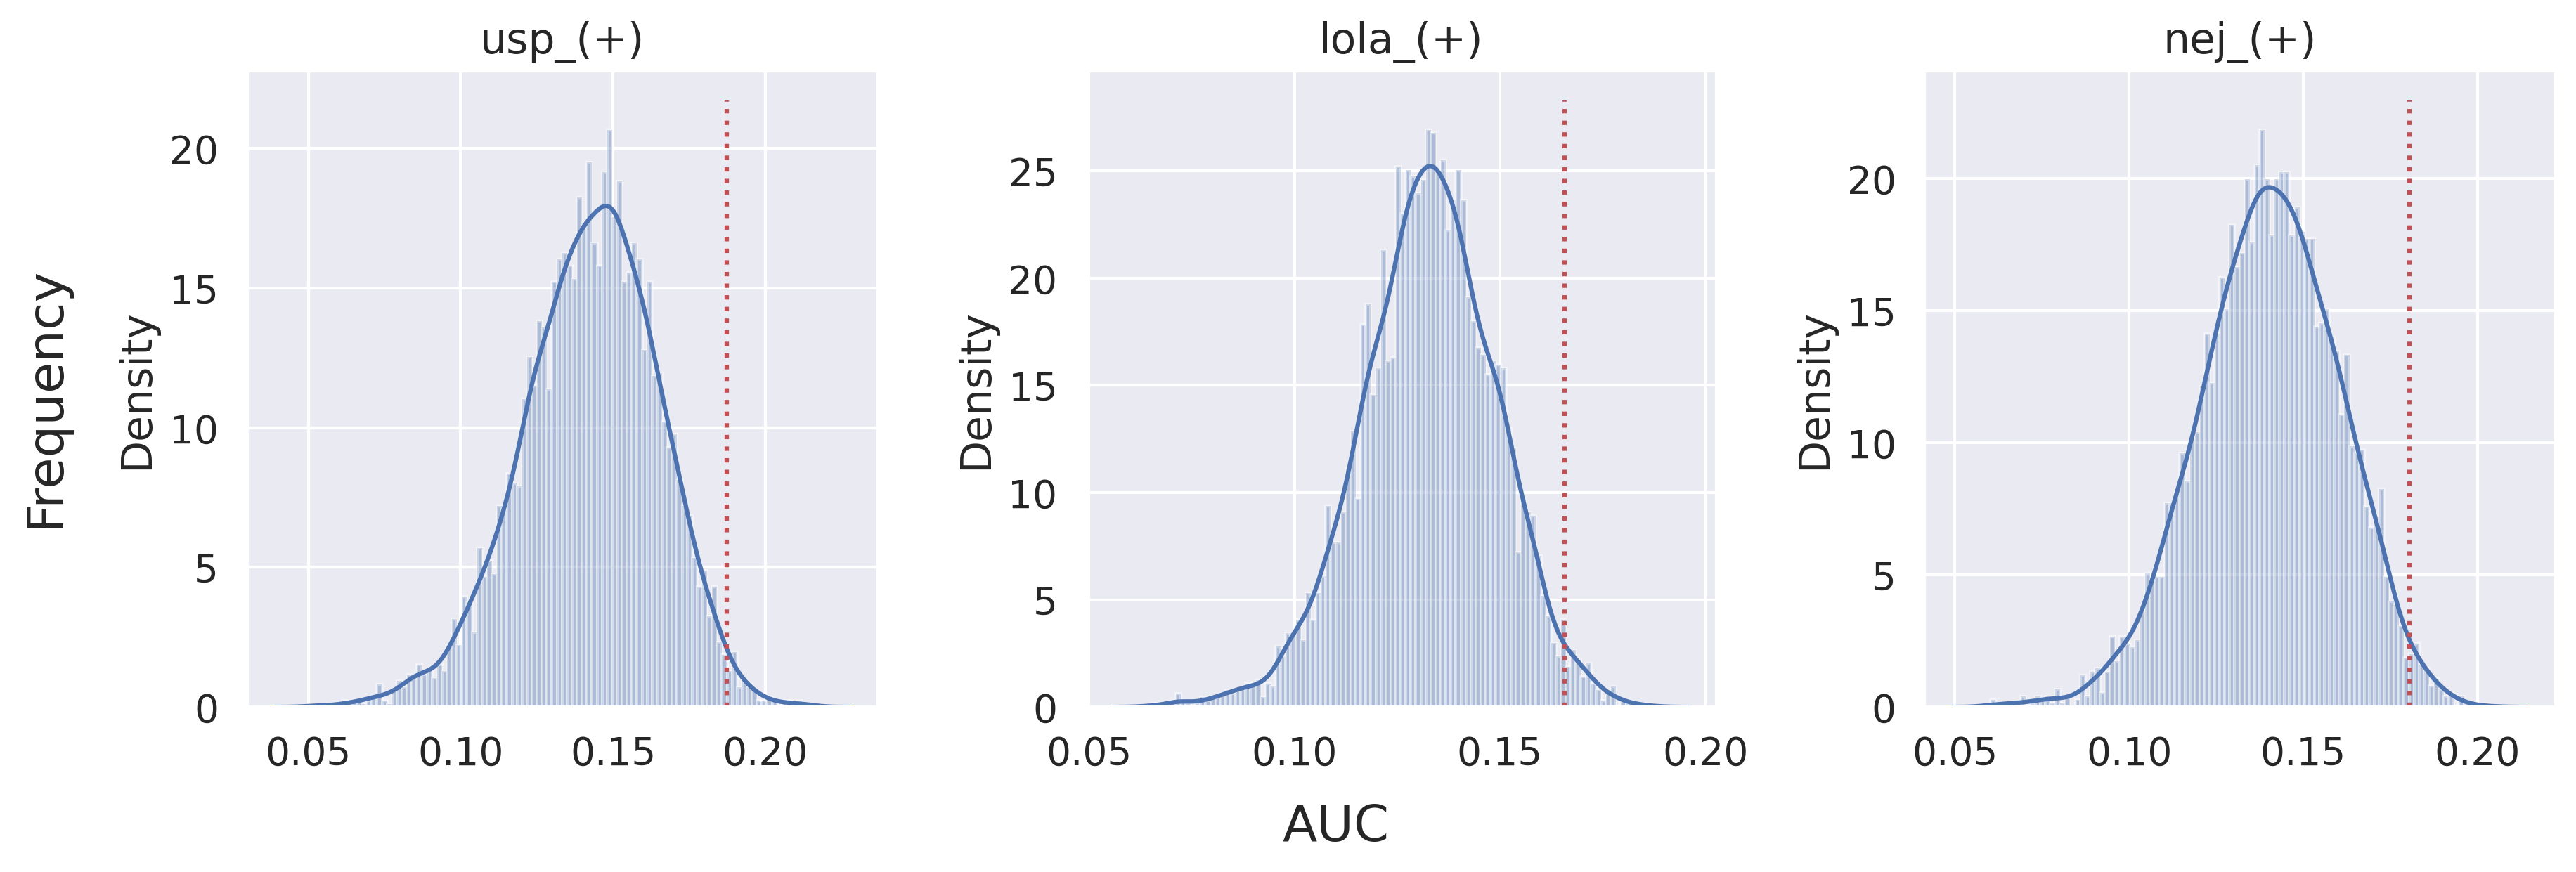

In [40]:
# select regulons:
r = ['usp_(+)','lola_(+)','nej_(+)' ]

fig, axs = plt.subplots(1, 3, figsize=(12, 4), dpi=150, sharey=False)
for i,ax in enumerate(axs):
    sns.distplot(auc_mtx[ r[i] ], ax=ax, norm_hist=True, bins=100)
    ax.plot( [ auc_thresholds[ r[i] ] ]*2, ax.get_ylim(), 'r:')
    ax.title.set_text( r[i] )
    ax.set_xlabel('')
    
fig.text(-0.01, 0.5, 'Frequency', ha='center', va='center', rotation='vertical', size='large')
fig.text(0.5, -0.01, 'AUC', ha='center', va='center', rotation='horizontal', size='large')

fig.tight_layout()
fig.savefig('Kenyon_Mutant_cellType-binaryPlot2.pdf', dpi=600, bbox_inches='tight')

# RSS Across Clusters

In [41]:
rss_louvain = regulon_specificity_scores( auc_mtx, cellAnnot['Louvain_clusters_Scanpy'] )
rss_louvain


BEAF-32_(+)  Blimp-1_(+)  BtbVII_(+)  CG5641_(+)  CG8319_(+)  Cdc5_(+)  \
15.0     0.430699     0.421813    0.411106    0.391591    0.389846  0.413984   
21.0     0.321714     0.314612    0.312029    0.307733    0.306728  0.329812   
10.0     0.526094     0.552455    0.532741    0.531426    0.554588  0.539552   

         D_(+)  E_(bx)_(+)  E_(spl)mgamma-HLH_(+)   ERR_(+)  ...    oc_(+)  \
15.0  0.345972    0.420523               0.266550  0.260480  ...  0.287079   
21.0  0.331198    0.314263               0.196370  0.305913  ...  0.240650   
10.0  0.336103    0.546842               0.254012  0.390669  ...  0.246285   

       pho_(+)  scro_(+)   sim_(+)    so_(+)   srp_(+)    tj_(+)   usp_(+)  \
15.0  0.425562  0.446438  0.250211  0.305313  0.349797  0.325749  0.436096   
21.0  0.328313  0.310696  0.351201  0.224005  0.270223  0.331266  0.315444   
10.0  0.535778  0.503005  0.234597  0.260187  0.321161  0.352729  0.540103   

       vvl_(+)  zfh2_(+)  
15.0  0.324716  0.412266  
21.0  0.245099  0.312638  
10.0  0.311897  0.566950  

[3 rows x 58 columns]

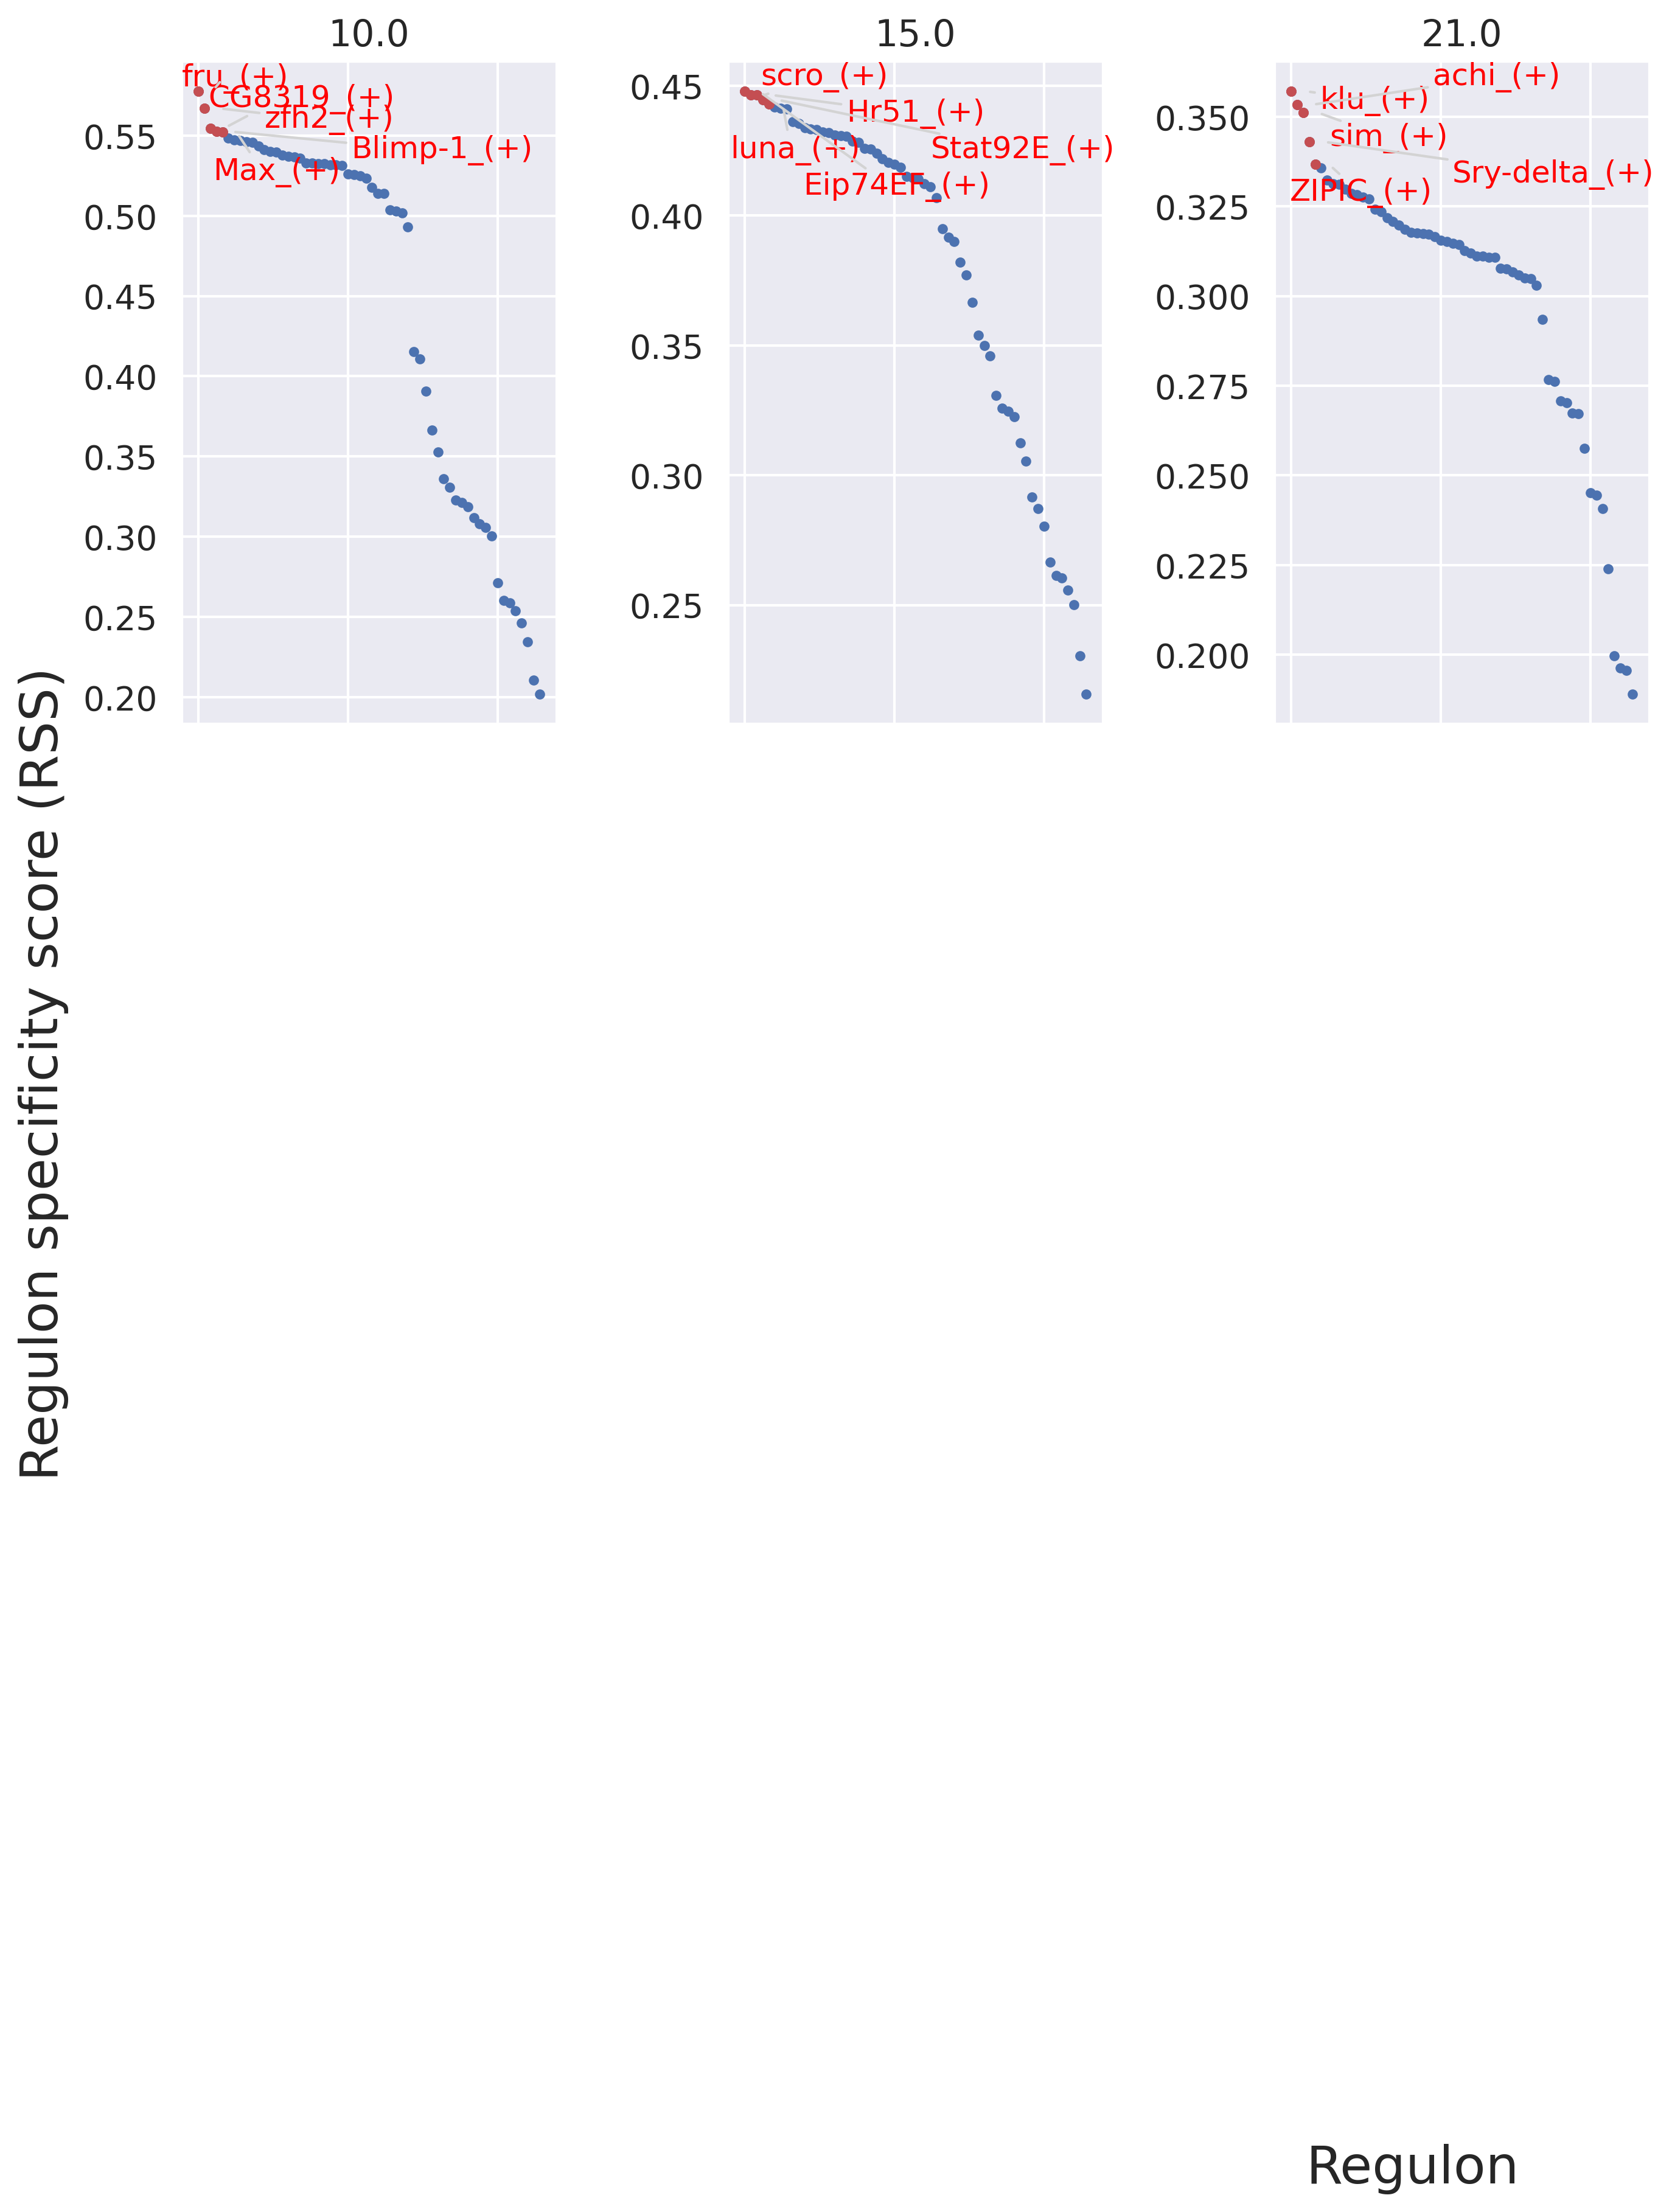

In [42]:
cats = sorted( list(set(cellAnnot['Louvain_clusters_Scanpy'])), key=int )

fig = plt.figure(figsize=(15, 12))
for c,num in zip(cats, range(1,len(cats)+1)):
    x=rss_louvain.T[c]
    ax = fig.add_subplot(3,5,num)
    plot_rss(rss_louvain, c, top_n=5, max_n=None, ax=ax)
    ax.set_ylim( x.min()-(x.max()-x.min())*0.05 , x.max()+(x.max()-x.min())*0.05 )
    for t in ax.texts:
        t.set_fontsize(12)
    ax.set_ylabel('')
    ax.set_xlabel('')
    adjust_text(ax.texts, autoalign='xy', ha='right', va='bottom', arrowprops=dict(arrowstyle='-',color='lightgrey'), precision=0.001 )
 
fig.text(0.5, 0.0, 'Regulon', ha='center', va='center', size='x-large')
fig.text(0.00, 0.5, 'Regulon specificity score (RSS)', ha='center', va='center', rotation='vertical', size='x-large')
plt.tight_layout()
plt.rcParams.update({
    'figure.autolayout': True,
        'figure.titlesize': 'large' ,
        'axes.labelsize': 'medium',
        'axes.titlesize':'large',
        'xtick.labelsize':'medium',
        'ytick.labelsize':'medium'
        })
plt.savefig("Kenyon_TauKI_Louvain-RSS-top5.png", dpi=150, bbox_inches = "tight")
plt.show()

In [43]:
topreg = []
for i,c in enumerate(cats):
    topreg.extend(
        list(rss_louvain.T[c].sort_values(ascending=False)[:5].index)
    )
topreg = list(set(topreg))

In [44]:
def palplot(pal, names, colors=None, size=1):
    n = len(pal)
    f, ax = plt.subplots(1, 1, figsize=(n * size, size))
    ax.imshow(np.arange(n).reshape(1, n),
              cmap=mpl.colors.ListedColormap(list(pal)),
              interpolation="nearest", aspect="auto")
    ax.set_xticks(np.arange(n) - .5)
    ax.set_yticks([-.5, .5])
    ax.set_xticklabels([])
    ax.set_yticklabels([])
    colors = n * ['k'] if colors is None else colors
    for idx, (name, color) in enumerate(zip(names, colors)):
        ax.text(0.0+idx, 0.0, name, color=color, horizontalalignment='center', verticalalignment='center')
    return f


In [45]:

colors = sns.color_palette('bright',n_colors=len(cats) )
colorsd = dict( zip( cats, colors ))
colormap = [ colorsd[x] for x in cellAnnot['Louvain_clusters_Scanpy'] ]

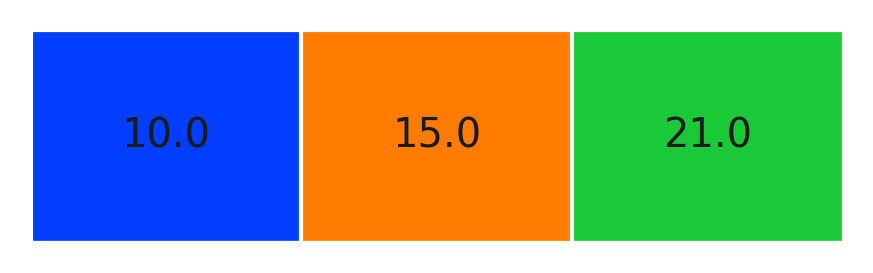

In [46]:
sns.set()
sns.set(font_scale=0.8)
fig = palplot( colors, cats, size=1.0)

/home/acicalo/miniconda3/envs/pyscenic/lib/python3.10/site-packages/seaborn/matrix.py:560: UserWarning: Clustering large matrix with scipy. Installing `fastcluster` may give better performance.
  warnings.warn(msg)


Text(0.5, -132.55833333333334, '')

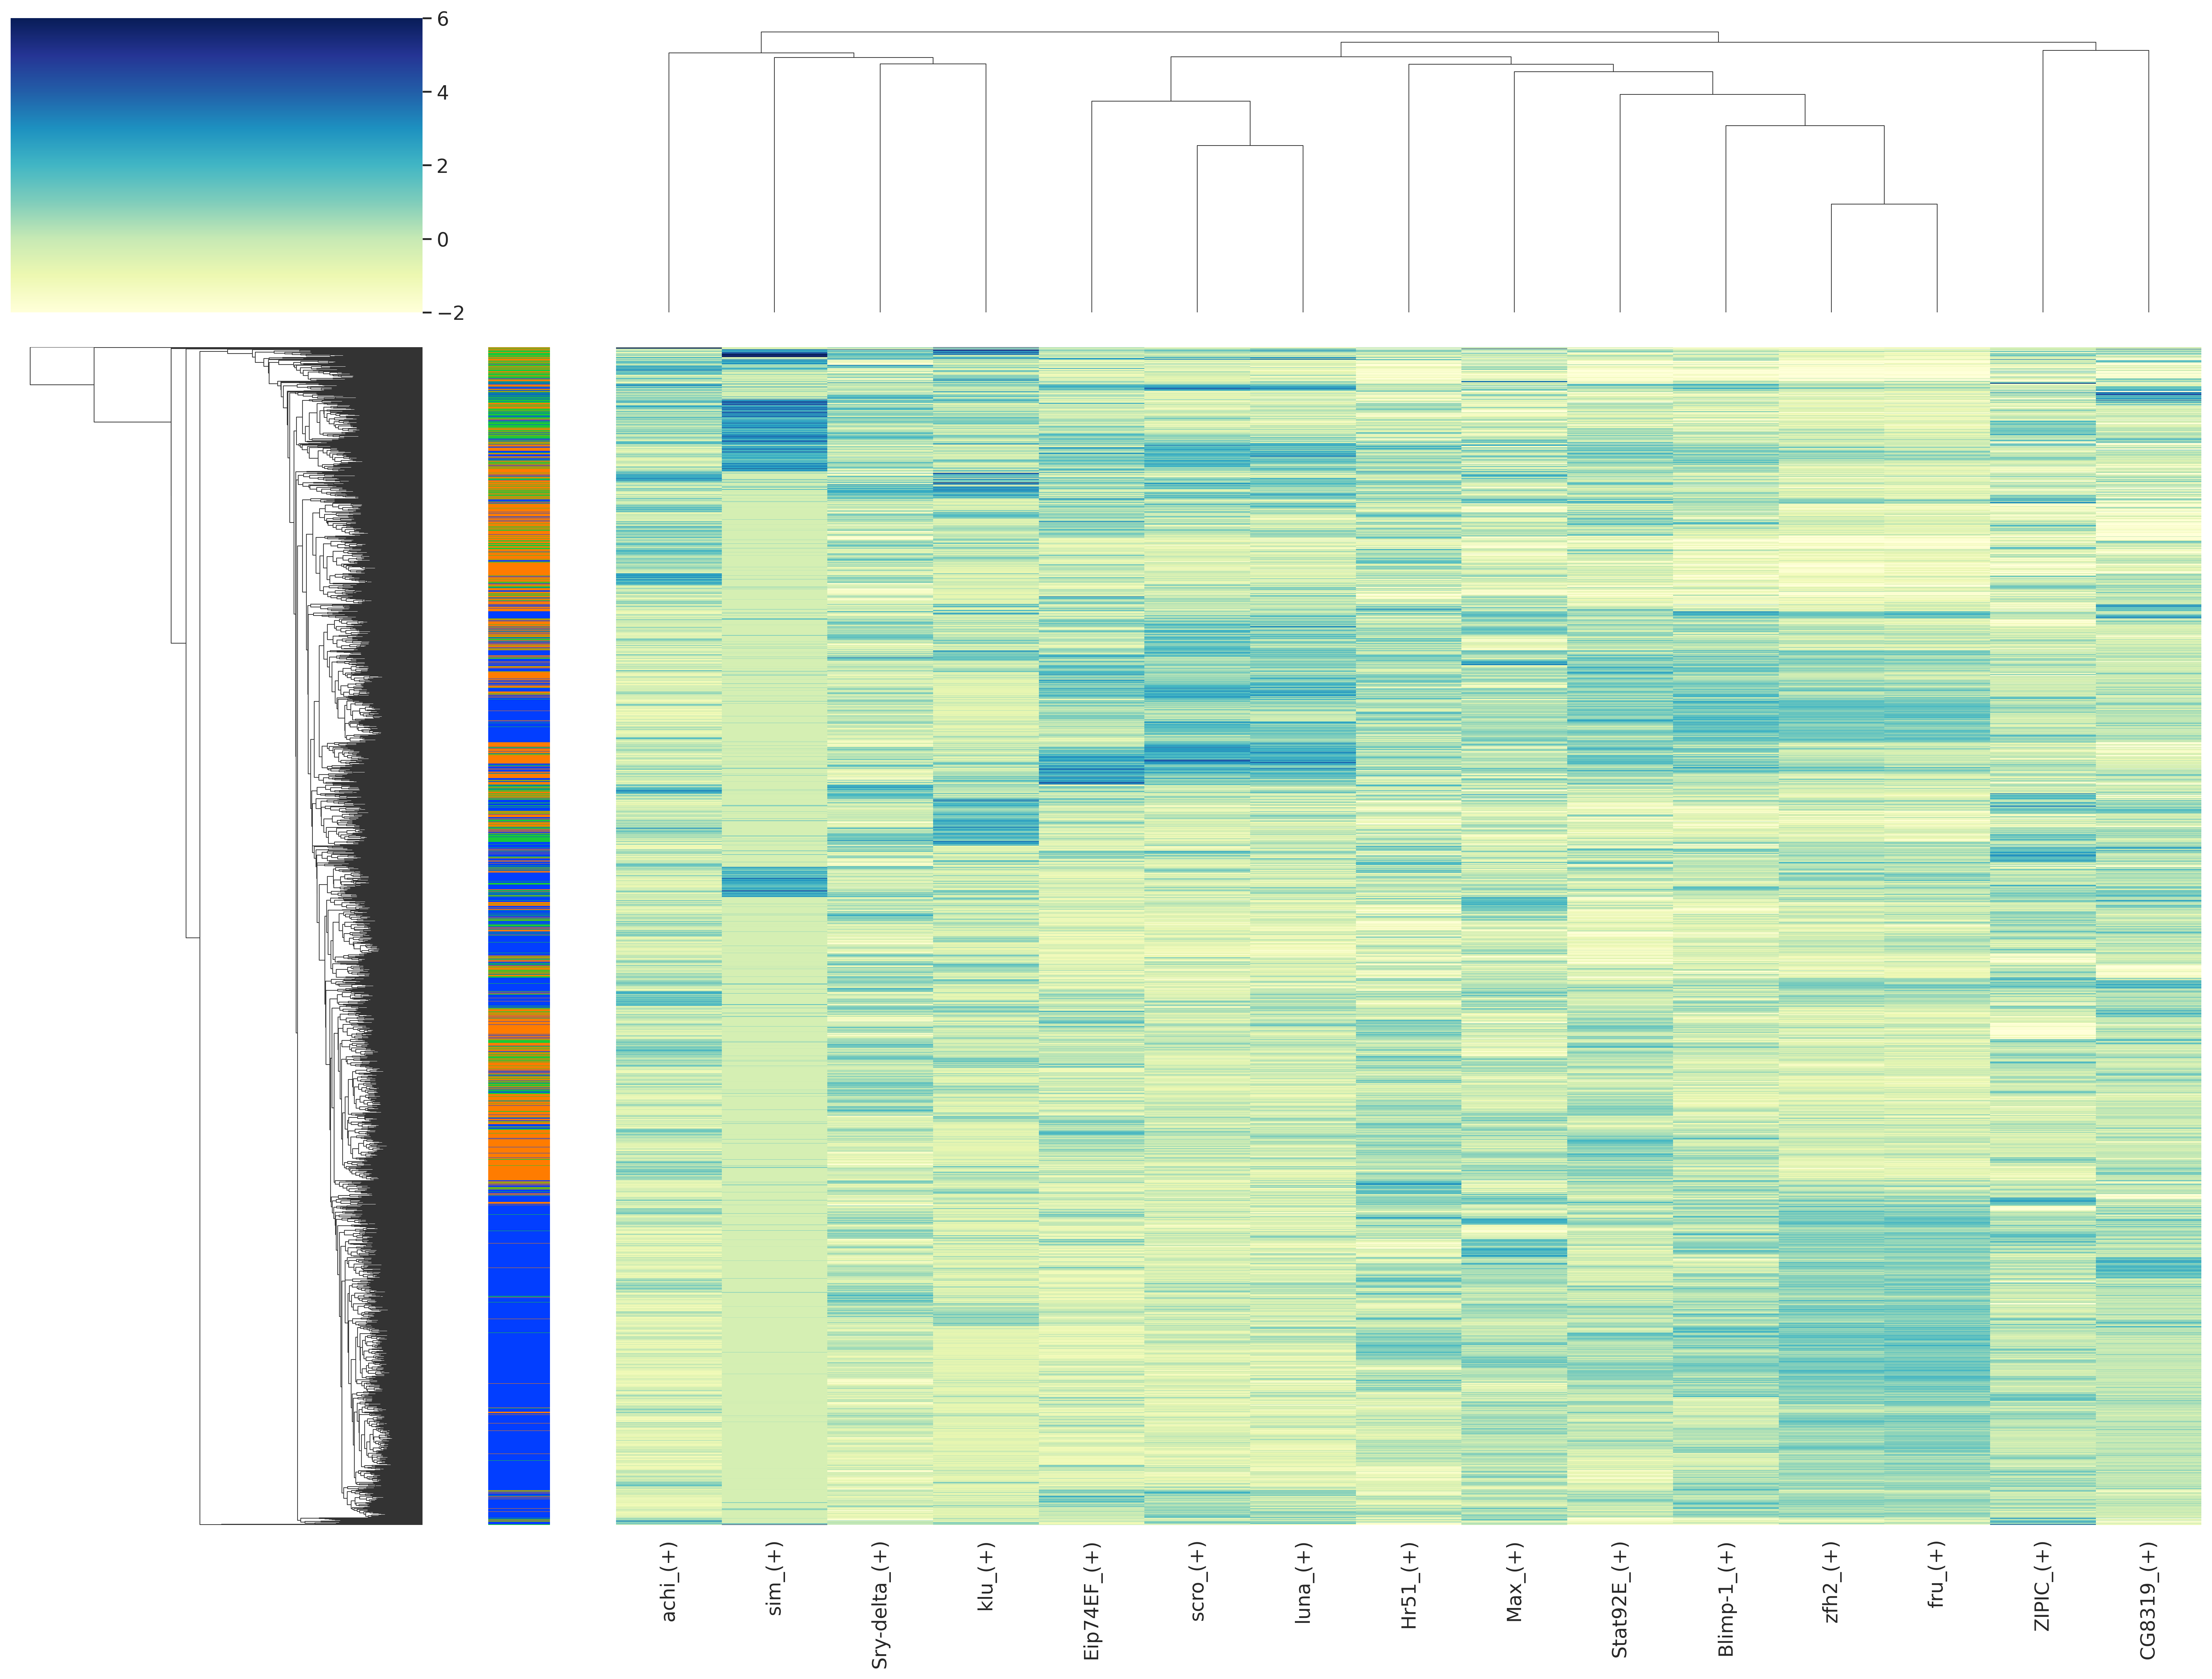

In [47]:

sns.set(font_scale=1.2)
g = sns.clustermap(auc_mtx_Z[topreg], annot=False,  square=False,  linecolor='gray',
    yticklabels=False, vmin=-2, vmax=6, row_colors=colormap,
    cmap="YlGnBu", figsize=(21,16) )
g.cax.set_visible(True)
g.ax_heatmap.set_ylabel('')    
g.ax_heatmap.set_xlabel('')    

# Further explore

In [6]:
adjacencies = pd.read_csv("TauKI_adj.csv", index_col=False)


In [7]:
from pyscenic.utils import modules_from_adjacencies
modules = list(modules_from_adjacencies(adjacencies, exprMat))


2023-09-06 13:14:51,793 - pyscenic.utils - INFO - Calculating Pearson correlations.

2023-09-06 13:14:52,073 - pyscenic.utils - WARNING - Note on correlation calculation: the default behaviour for calculating the correlations has changed after pySCENIC verion 0.9.16. Previously, the default was to calculate the correlation between a TF and target gene using only cells with non-zero expression values (mask_dropouts=True). The current default is now to use all cells to match the behavior of the R verision of SCENIC. The original settings can be retained by setting 'rho_mask_dropouts=True' in the modules_from_adjacencies function, or '--mask_dropouts' from the CLI.
	Dropout masking is currently set to [False].

2023-09-06 13:15:03,999 - pyscenic.utils - INFO - Creating modules.


In [12]:
tf = 'Pur-alpha'
tf_mods = [ x for x in modules if x.transcription_factor==tf ]

for i,mod in enumerate( tf_mods ):
    print( f'{tf} module {str(i)}: {len(mod.genes)} genes' )
print( f'{tf} regulon: {len(regulons[tf+"_(+)"])} genes' )

Pur-alpha module 0: 589 genes
Pur-alpha module 1: 286 genes
Pur-alpha module 2: 51 genes
Pur-alpha module 3: 72 genes
Pur-alpha module 4: 193 genes
Pur-alpha module 5: 836 genes
Pur-alpha regulon: 204 genes


In [13]:
for i,mod in enumerate( tf_mods ):
    with open( tf+'_module_'+str(i)+'.txt', 'w') as f:
        for item in mod.genes:
            f.write("%s\n" % item)
            
with open( tf+'_regulon.txt', 'w') as f:
    for item in regulons[tf+'_(+)']:
        f.write("%s\n" % item)